# Clustering Exploratory Data Analysis
Notebook to perform clustering analysis on data on BigQuery.<br>

## Imports

In [1]:
import calendar
from tqdm.auto import tqdm
import json
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from google.cloud import bigquery
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
import seaborn as sns
from collections import Counter
from itertools import product

import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')

my_cmap = plt.get_cmap("Paired")

## Config

In [2]:
# Config

PROJECT_ID = 'arpae-prod-ml'

# BigQuery
JOINED_BQ_DATASET = 'JOINED_DATA'
JOINED_DATA_TABLE = "ALL_METEO_FEATS_POL_DAT"
JOINED_WEEK_DATA_TABLE = "ALL_METEO_WEEK_FEATS_POL_DAT"

# Paths
BCODES_PATHS = "data/b_codes.json"
OUTPUT_CLUSTER_FILENAME = "./data/clustering_tsd_intervals.csv"

# Layout
COLOR_PALETTE = px.colors.qualitative.Prism


## Methods

In [3]:
# # Read Methods

def _run_query(client, query): 
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

def _show_distr_in_clusters(df, col, title):
    df_list = []
    for cluster_id in sorted(df.cluster.unique()):
        curr_df = df[df["cluster"]==cluster_id]
        station_dict = {}
        for station_id in curr_df[col].unique():
            station_dict[station_id] = curr_df[col].values.tolist().count(station_id)
        df_list.append(station_dict)
    station_distr_df = pd.DataFrame(df_list)

    fig = px.imshow(station_distr_df, text_auto=True, title='{} distribution in clusters'.format(title))
    fig.update_xaxes(title_text=title, tickmode='linear')
    fig.update_yaxes(title_text='Clusters', tickmode='linear')
    fig.show()

def _show_bcode_in_how_many_clusters(df):
    bcode_distr = {}
    for pol_var_id in sorted(df.pol_var_id.unique()):
        curr_df = df[df["pol_var_id"]==pol_var_id]
        bcode_distr[pol_var_id] = curr_df['cluster'].nunique()
    bcode_distr = dict(sorted(bcode_distr.items(), key=lambda item: item[1]))

    fig = go.Figure()
    fig = px.bar(title="",
                 x=bcode_distr.keys(), 
                 y=bcode_distr.values(),
                 color_discrete_sequence=COLOR_PALETTE,
                 template="simple_white")
    fig.update_xaxes(title_text='b_code', showgrid=True)
    fig.update_yaxes(title_text='in how many cluster', showgrid=True, tickmode='linear', range=[0, df.cluster.nunique()])
    fig.show()

# 1. Read Data

## 1.1 Config BigQuery

In [4]:
# Setup Client

bq_client = bigquery.Client()
bq_client

## 1.2 Read Tables

In [5]:
# Load B_CODES

sql = f"SELECT * FROM `{PROJECT_ID}.SAMPLE_DATA.B_CODES` WHERE eligible IS true"
b_codes = _run_query(bq_client, sql)

print(b_codes.shape)
b_codes.head(3)

(33, 3)


var_id                                  var_descr  eligible
0  B48026  Mirtacee_Mirtacee indistinte, POLLEN/M**3      True
1  B48006           Composite_Artemisia, POLLEN/M**3      True
2  B48041     Spore fungine_Stemphylium, POLLEN/M**3      True

In [6]:
# Load BCODE_SOGLIE

sql = f"SELECT * FROM `{PROJECT_ID}.SAMPLE_DATA.BCODE_SOGLIE`"
b_codes_soglie = _run_query(bq_client, sql)
b_codes_soglie.head(3)

b_code  basso  medio  alto  CAL_01_JAN  CAL_02_FEB  CAL_03_MAR  CAL_04_APR  \
0  B48066    0.0    0.0     0        <NA>        <NA>        <NA>        <NA>   
1  B48081    3.0   25.0    50        <NA>        <NA>        <NA>        <NA>   
2  B48082    3.0   25.0    50        <NA>        <NA>        <NA>        <NA>   

   CAL_05_MAY  CAL_06_JUN  CAL_07_JUL  CAL_08_AUG  CAL_09_SEP  CAL_10_OCT  \
0        <NA>        <NA>        <NA>        <NA>        <NA>        <NA>   
1        <NA>        <NA>        <NA>        <NA>        <NA>        <NA>   
2        <NA>        <NA>        <NA>        <NA>        <NA>        <NA>   

   CAL_11_NOV  CAL_12_DEC  
0        <NA>        <NA>  
1        <NA>        <NA>  
2        <NA>        <NA>

In [7]:
# Load all meteo and pollen data

sql = f"""
    SELECT DISTINCT *
    FROM `{PROJECT_ID}.{JOINED_BQ_DATASET}.{JOINED_DATA_TABLE}`
    WHERE pol_var_id IN {tuple(b_codes.var_id)}
    ORDER BY station_id, pol_var_id, date
"""

df = _run_query(bq_client, sql)

print(df.shape)
df.head(3)

(1362096, 30)


station_id        date  B13011_min  B13011_max  B13011_mean  B13011_std  \
0           1  2006-03-01         0.0         0.0          0.0         0.0   
1           1  2006-03-02         0.0         0.0          0.0         0.0   
2           1  2006-03-03         0.0         0.0          0.0         0.0   

   B14198_min  B14198_max  B14198_mean  B14198_std  ...      arkimet_id  \
0       -11.0       588.0       138.76  200.669770  ...  Bologna urbana   
1        -6.0       351.0        61.56   98.767015  ...  Bologna urbana   
2        -5.0       406.0        87.12  133.675702  ...  Bologna urbana   

   arkimet_lat  arkimet_lon  meteo_id  pol_var_id  pol_value  modified  \
0      44.5008      11.3288     01421      B48001        0.0         1   
1      44.5008      11.3288     01421      B48001        0.0         1   
2      44.5008      11.3288     01421      B48001        0.0         1   

                                   pol_var_descr  week  year  
0  Graminacee_Graminacee indistinte, POLLEN/M**3     9  2006  
1  Graminacee_Graminacee indistinte, POLLEN/M**3     9  2006  
2  Graminacee_Graminacee indistinte, POLLEN/M**3     9  2006  

[3 rows x 30 columns]

# 2. Data preprocess

In [8]:
# Sort dataframes
df.sort_values(["pol_var_id", "date"], inplace=True)

In [9]:
# Convert dates to datetime format
df.date = pd.to_datetime(df.date)

# df["month"] = df.date.dt.month
# df["day"] = df.date.dt.day

In [10]:
# Set label as pair station_polvarid
df["station_pol_id"] = df.station_id.astype(str) + "_" + df.pol_var_id

In [11]:
# Create df with features only
# pollen_features = ["station_id", "pol_var_id", "date", "pol_value"]
pollen_features = ["station_pol_id", "date", "pol_value"]
pollen = df[pollen_features].copy()

print(pollen.shape)
pollen.head(3)

(1362096, 3)


station_pol_id       date  pol_value
0            1_B48001 2006-03-01        0.0
139239       2_B48001 2006-03-01        0.0
249456       4_B48001 2006-03-01        0.0

In [12]:
# Set datetime as index
pollen.set_index('date', inplace=True)

pollen.head(3)

station_pol_id  pol_value
date                                
2006-03-01       1_B48001        0.0
2006-03-01       2_B48001        0.0
2006-03-01       4_B48001        0.0

In [ ]:
wcss = []
silhouette_scores = []
cluster_ranges = list(range(2, 33))
X.drop("cluster", axis=1, inplace=True, errors="ignore")

for i in tqdm(cluster_ranges):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(14, 4))
ax1.plot(cluster_ranges, wcss)
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax1.set_xticks(cluster_ranges)
ax1.grid(alpha=.3)

ax2.plot(cluster_ranges, silhouette_scores)
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette')
ax2.set_xticks(cluster_ranges)
ax2.grid(alpha=.3)

plt.tight_layout();

In [ ]:
X.drop("cluster", axis=1, inplace=True, errors="ignore")

optimal_clustern = 10
clusterer = KMeans(n_clusters=optimal_clustern).fit(X)

X["cluster"] = clusterer.labels_
print(Counter(clusterer.labels_))

___

# 3. Time Series Decomposition

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
### Aggregate features
def get_windowed_features(df, time_window):
    df = df.groupby(["station_pol_id", pd.Grouper(freq=time_window)]).sum()
    df.reset_index(inplace=True)
    df.sort_values("date", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [16]:
# Get windowed features
df_feat = get_windowed_features(pollen, time_window="1W")

# Pivot dataframe
df_feat = pd.pivot_table(df_feat, values="pol_value", index="station_pol_id", columns="date")

# # Min max scale per specie
df_feat = df_feat.apply(min_max_scale, axis=1).fillna(0)

# Library needs date and specie column as data serie
df_series = df_feat.T#.reset_index()

print(df_series.shape)
df_series.head(5)

(836, 363)


station_pol_id  10_B48001  10_B48002  10_B48003  10_B48005  10_B48006  \
date                                                                    
2006-01-01            0.0   0.000000        0.0        0.0        0.0   
2006-01-08            0.0   0.000766        0.0        0.0        0.0   
2006-01-15            0.0   0.000000        0.0        0.0        0.0   
2006-01-22            0.0   0.000000        0.0        0.0        0.0   
2006-01-29            0.0   0.000000        0.0        0.0        0.0   

station_pol_id  10_B48007  10_B48008  10_B48011  10_B48012  10_B48013  ...  \
date                                                                   ...   
2006-01-01            0.0        0.0        0.0        0.0        0.0  ...   
2006-01-08            0.0        0.0        0.0        0.0        0.0  ...   
2006-01-15            0.0        0.0        0.0        0.0        0.0  ...   
2006-01-22            0.0        0.0        0.0        0.0        0.0  ...   
2006-01-29            0.0        0.0        0.0        0.0        0.0  ...   

station_pol_id  9_B48032  9_B48033  9_B48034  9_B48036  9_B48037  9_B48038  \
date                                                                         
2006-01-01           0.0       0.0       0.0       0.0       0.0       0.0   
2006-01-08           0.0       0.0       0.0       0.0       0.0       0.0   
2006-01-15           0.0       0.0       0.0       0.0       0.0       0.0   
2006-01-22           0.0       0.0       0.0       0.0       0.0       0.0   
2006-01-29           0.0       0.0       0.0       0.0       0.0       0.0   

station_pol_id  9_B48039  9_B48041  9_B48044  9_B48045  
date                                                    
2006-01-01           0.0       0.0       0.0       0.0  
2006-01-08           0.0       0.0       0.0       0.0  
2006-01-15           0.0       0.0       0.0       0.0  
2006-01-22           0.0       0.0       0.0       0.0  
2006-01-29           0.0       0.0       0.0       0.0  

[5 rows x 363 columns]

## 3.1 Time series decomposition

In [17]:
# date_col = "date"
specie_decomposition = {}
for specie_id in tqdm(df_series.columns):
    specie_decomposition[specie_id] = seasonal_decompose(
        df_series[specie_id],
        #period=12,
        model='additive'
    )

df_seasonal = {specie_id: specie_decomposition[specie_id].seasonal for specie_id in specie_decomposition }
df_seasonal = pd.DataFrame(df_seasonal)
df_seasonal

  0%|          | 0/363 [00:00<?, ?it/s]

10_B48001  10_B48002  10_B48003  10_B48005  10_B48006  10_B48007  \
date                                                                           
2006-01-01  -0.029997  -0.017871  -0.022753  -0.009108  -0.021434  -0.068694   
2006-01-08  -0.030046  -0.018008  -0.022446  -0.009108  -0.021431  -0.067985   
2006-01-15  -0.030154  -0.017578  -0.022753  -0.009108  -0.021431  -0.067706   
2006-01-22  -0.030248  -0.014610  -0.021677  -0.009110  -0.021424  -0.068065   
2006-01-29  -0.030293  -0.008064  -0.020338  -0.009112  -0.021406  -0.068620   
...               ...        ...        ...        ...        ...        ...   
2021-12-05  -0.029991  -0.017871  -0.022750  -0.009106  -0.021438  -0.069337   
2021-12-12  -0.029997  -0.017871  -0.022753  -0.009108  -0.021434  -0.068694   
2021-12-19  -0.030046  -0.018008  -0.022446  -0.009108  -0.021431  -0.067985   
2021-12-26  -0.030154  -0.017578  -0.022753  -0.009108  -0.021431  -0.067706   
2022-01-02  -0.030248  -0.014610  -0.021677  -0.009110  -0.021424  -0.068065   

            10_B48008  10_B48011  10_B48012  10_B48013  ...  9_B48032  \
date                                                    ...             
2006-01-01  -0.022851  -0.021919  -0.012243  -0.009266  ... -0.011520   
2006-01-08  -0.022463  -0.021680  -0.012243  -0.009268  ... -0.011524   
2006-01-15  -0.018654  -0.021856  -0.012243  -0.009270  ... -0.011525   
2006-01-22   0.030251  -0.022341  -0.012243  -0.009270  ... -0.011531   
2006-01-29   0.039962  -0.022924  -0.012243  -0.009270  ... -0.011541   
...               ...        ...        ...        ...  ...       ...   
2021-12-05  -0.022444  -0.022293  -0.012243  -0.009261  ... -0.011477   
2021-12-12  -0.022851  -0.021919  -0.012243  -0.009266  ... -0.011520   
2021-12-19  -0.022463  -0.021680  -0.012243  -0.009268  ... -0.011524   
2021-12-26  -0.018654  -0.021856  -0.012243  -0.009270  ... -0.011525   
2022-01-02   0.030251  -0.022341  -0.012243  -0.009270  ... -0.011531   

            9_B48033  9_B48034  9_B48036  9_B48037  9_B48038  9_B48039  \
date                                                                     
2006-01-01 -0.012984 -0.017323 -0.021957 -0.007755 -0.005093 -0.081826   
2006-01-08 -0.012984 -0.017323 -0.021957 -0.007755 -0.005093 -0.082270   
2006-01-15 -0.012984 -0.017277 -0.021957 -0.007755 -0.005093 -0.082900   
2006-01-22 -0.012984 -0.017323 -0.021957 -0.007755 -0.005093 -0.084140   
2006-01-29 -0.012984 -0.017231 -0.021957 -0.007755 -0.005093 -0.084443   
...              ...       ...       ...       ...       ...       ...   
2021-12-05 -0.012984 -0.017269 -0.021864 -0.007734 -0.005093 -0.079542   
2021-12-12 -0.012984 -0.017323 -0.021957 -0.007755 -0.005093 -0.081826   
2021-12-19 -0.012984 -0.017323 -0.021957 -0.007755 -0.005093 -0.082270   
2021-12-26 -0.012984 -0.017277 -0.021957 -0.007755 -0.005093 -0.082900   
2022-01-02 -0.012984 -0.017323 -0.021957 -0.007755 -0.005093 -0.084140   

            9_B48041  9_B48044  9_B48045  
date                                      
2006-01-01 -0.046860 -0.053411 -0.042145  
2006-01-08 -0.046790 -0.053376 -0.042170  
2006-01-15 -0.046630 -0.053354 -0.042247  
2006-01-22 -0.046561 -0.053400 -0.042446  
2006-01-29 -0.046577 -0.053432 -0.042680  
...              ...       ...       ...  
2021-12-05 -0.046770 -0.053365 -0.041995  
2021-12-12 -0.046860 -0.053411 -0.042145  
2021-12-19 -0.046790 -0.053376 -0.042170  
2021-12-26 -0.046630 -0.053354 -0.042247  
2022-01-02 -0.046561 -0.053400 -0.042446  

[836 rows x 363 columns]

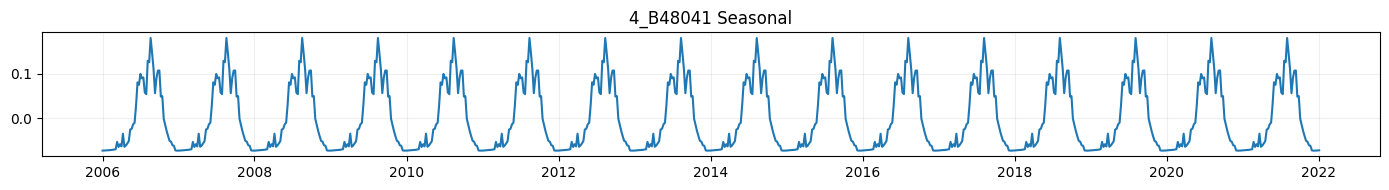

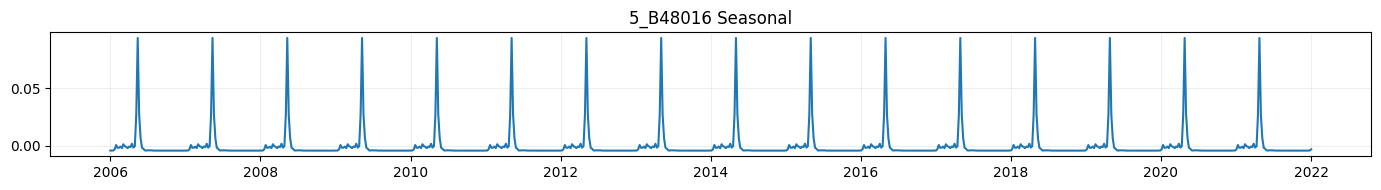

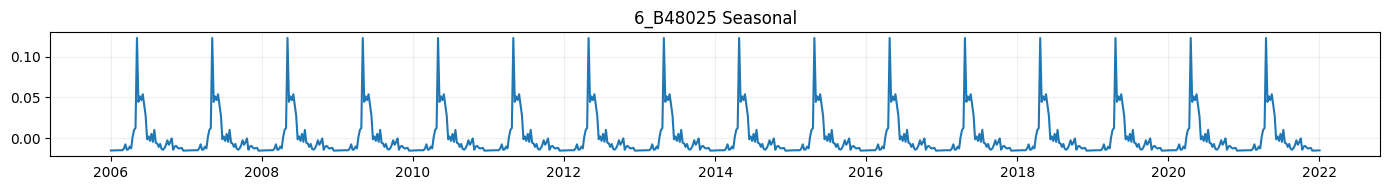

In [18]:
for specie_id in np.random.choice(df_seasonal.columns, 3):
    plt.figure(figsize=(14,2))
    plt.title(f"{specie_id} Seasonal")
    plt.plot(df_seasonal[specie_id])
    plt.tight_layout()
    plt.grid(alpha=.2)
    plt.show()

  0%|          | 0/31 [00:00<?, ?it/s]

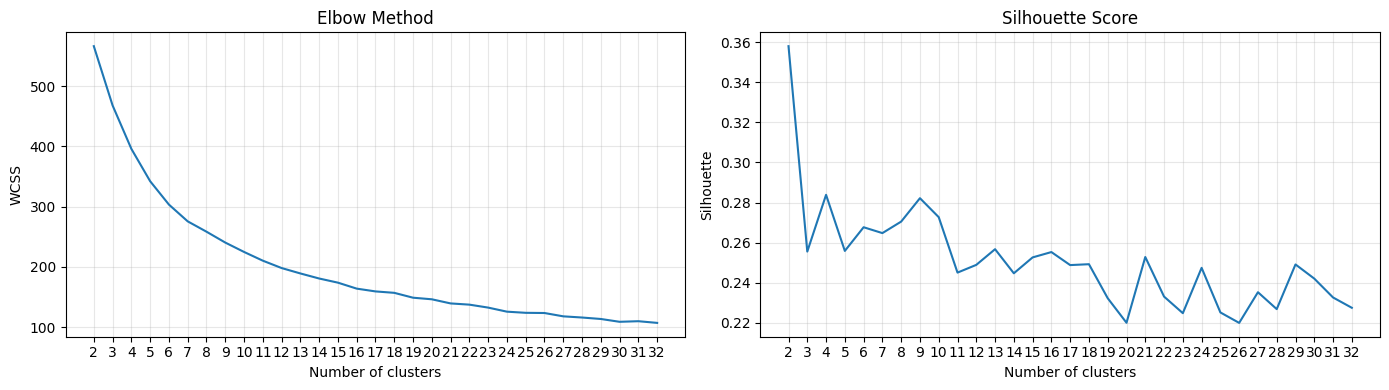

In [19]:
df_seasonal_transposed = df_seasonal.T

wcss = []
silhouette_scores = []
cluster_ranges = list(range(2, 33))
df_seasonal_transposed.drop("cluster", axis=1, inplace=True, errors="ignore")

for i in tqdm(cluster_ranges):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_seasonal_transposed)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_seasonal_transposed, kmeans.labels_))
    
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(14, 4))
ax1.plot(cluster_ranges, wcss)
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax1.set_xticks(cluster_ranges)
ax1.grid(alpha=.3)

ax2.plot(cluster_ranges, silhouette_scores)
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette')
ax2.set_xticks(cluster_ranges)
ax2.grid(alpha=.3)

plt.tight_layout();

## 3.2 Optimal parameter for TSD

In [20]:
def clustering_pipeline(time_window, period):
    print(f"Clustering - time_window: {time_window} - period: {period}")

    ### Preparing data
    # Get windowed features
    df_feat = get_windowed_features(pollen, time_window=time_window)
    
    # Dropping cluster label, if any
    df_feat.drop("cluster", axis=1, inplace=True, errors="ignore")

    # Pivot dataframe
    df_feat = pd.pivot_table(df_feat, values="pol_value", index="station_pol_id", columns="date")

    # # Min max scale per specie
    df_feat = df_feat.apply(min_max_scale, axis=1).fillna(0)

    # Library needs date and specie column as data serie
    df_series = df_feat.T
    
    ### Trend decomposition
    specie_decomposition = {}
    for specie_id in df_series.columns:
        specie_decomposition[specie_id] = seasonal_decompose(
            df_series[specie_id],
            period=period,
            model='additive'
        ).seasonal
    df_seasonal = pd.DataFrame(specie_decomposition)
    df_seasonal_T = df_seasonal.T

    ### Clustering
    wcss, silhouettes = [], []
    #for i in tqdm(cluster_ranges):
    for i in cluster_ranges:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(df_seasonal_T)
        wcss.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(df_seasonal_T, kmeans.labels_))

    return {
        "time_window": time_window,
        "period": period,
        "wcss": wcss,
        "silhouettes": silhouettes
    }

cluster_ranges = list(range(2, 33))
time_windows = ["10D", "1W", "5D"]
seasonal_periods = [None, 7, 10, 30]
results = [clustering_pipeline(t,p) for t,p in product(time_windows, seasonal_periods)]

results = pd.DataFrame(results)
results

Clustering - time_window: 10D - period: None
Clustering - time_window: 10D - period: 7
Clustering - time_window: 10D - period: 10
Clustering - time_window: 10D - period: 30
Clustering - time_window: 1W - period: None
Clustering - time_window: 1W - period: 7
Clustering - time_window: 1W - period: 10
Clustering - time_window: 1W - period: 30
Clustering - time_window: 5D - period: None
Clustering - time_window: 5D - period: 7
Clustering - time_window: 5D - period: 10
Clustering - time_window: 5D - period: 30


time_window  period                                               wcss  \
0          10D     NaN  [9.029966026902141, 7.49556842761257, 6.636134...   
1          10D     7.0  [9.029892462308116, 7.495635065005498, 6.63474...   
2          10D    10.0  [13.153929345130944, 11.7267955977145, 10.9510...   
3          10D    30.0  [52.395172705650445, 49.526079356843475, 47.51...   
4           1W     NaN  [566.3283519921142, 468.0154149816131, 395.941...   
5           1W     7.0  [6.478496702264882, 5.483561640823962, 4.83754...   
6           1W    10.0  [11.691110924769198, 10.025893780736855, 9.128...   
7           1W    30.0  [44.75432598347625, 42.25225973486015, 40.2488...   
8           5D     NaN  [5.303229177381071, 4.410211618070173, 3.88748...   
9           5D     7.0  [5.30322917738107, 4.4102704251602844, 3.88740...   
10          5D    10.0  [8.413494957564309, 7.363162543956133, 6.82433...   
11          5D    30.0  [33.390375964475155, 31.86780215189373, 30.405...   

                                          silhouettes  
0   [0.21683878123841036, 0.20312208142159668, 0.1...  
1   [0.21741901527788027, 0.20322751064872543, 0.1...  
2   [0.15082050412810571, 0.13722964471189264, 0.1...  
3   [0.12416867662711478, 0.07736985109813739, 0.0...  
4   [0.3579424368463218, 0.2572063824668779, 0.283...  
5   [0.19360109946109708, 0.18312384393272646, 0.1...  
6   [0.19086646932626147, 0.16774460048645562, 0.1...  
7   [0.10629758341632341, 0.06499509517091076, 0.0...  
8   [0.19147978213400701, 0.1930425223264627, 0.17...  
9   [0.19147978213400701, 0.19331895615067385, 0.1...  
10  [0.12855971667580204, 0.13681007552390329, 0.1...  
11  [0.06715550851553698, 0.061366198456703644, 0....

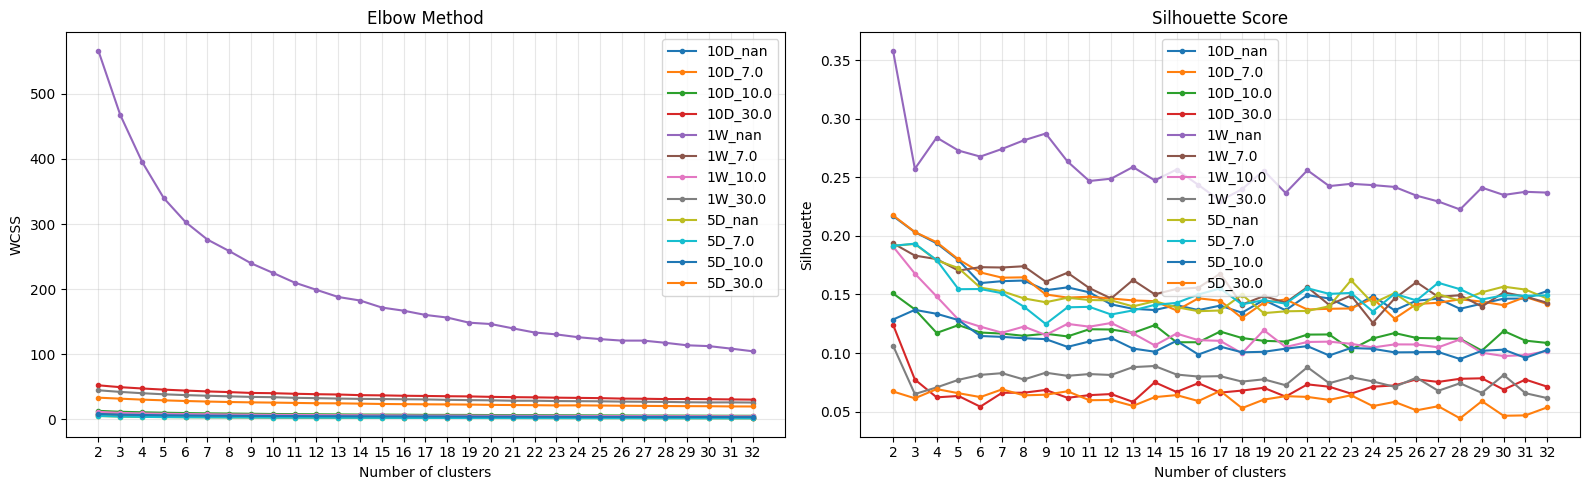

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.set_title("Elbow Method")
ax2.set_title("Silhouette Score")
ax1.set_xlabel('Number of clusters');
ax2.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS');
ax2.set_ylabel('Silhouette')

for _, res in results.iterrows():
    prd = "_"+str(res.period) if res.period else ""
    ax1.plot(cluster_ranges, res.wcss, label=res.time_window+prd, marker='.')
    ax2.plot(cluster_ranges, res.silhouettes, label=res.time_window+prd , marker='.')

ax1.set_xticks(cluster_ranges); ax2.set_xticks(cluster_ranges)
ax1.grid(alpha=.3); ax2.grid(alpha=.3)
ax1.legend(); ax2.legend()
plt.tight_layout()

___

# 4. Clustering Species using seasonal trends

## 4.1 Cluster

In [17]:
optimal_clustern = 12
optimal_window = "1W"
optimal_period = None

In [18]:
# Get windowed features
df_feat = get_windowed_features(pollen, time_window=optimal_window)

# Pivot dataframe
df_feat = pd.pivot_table(df_feat, values="pol_value", index="station_pol_id", columns="date")

# # Min max scale per specie
df_feat = df_feat.apply(min_max_scale, axis=1).fillna(0)

# Library needs date and specie column as data serie
df_feat = df_feat.T

### Trend decomposition
specie_decomposition = {}
for specie_id in df_feat.columns:
    specie_decomposition[specie_id] = seasonal_decompose(
        df_feat[specie_id],
        period=optimal_period,
        model='additive'
    ).seasonal
X = pd.DataFrame(specie_decomposition).T
X

date       2006-01-01  2006-01-08  2006-01-15  2006-01-22  2006-01-29  \
10_B48001   -0.029997   -0.030046   -0.030154   -0.030248   -0.030293   
10_B48002   -0.017871   -0.018008   -0.017578   -0.014610   -0.008064   
10_B48003   -0.022753   -0.022446   -0.022753   -0.021677   -0.020338   
10_B48005   -0.009108   -0.009108   -0.009108   -0.009110   -0.009112   
10_B48006   -0.021434   -0.021431   -0.021431   -0.021424   -0.021406   
...               ...         ...         ...         ...         ...   
9_B48038    -0.005093   -0.005093   -0.005093   -0.005093   -0.005093   
9_B48039    -0.081826   -0.082270   -0.082900   -0.084140   -0.084443   
9_B48041    -0.046860   -0.046790   -0.046630   -0.046561   -0.046577   
9_B48044    -0.053411   -0.053376   -0.053354   -0.053400   -0.053432   
9_B48045    -0.042145   -0.042170   -0.042247   -0.042446   -0.042680   

date       2006-02-05  2006-02-12  2006-02-19  2006-02-26  2006-03-05  ...  \
10_B48001   -0.030311   -0.030331   -0.030347   -0.030357   -0.030360  ...   
10_B48002   -0.002084    0.013653    0.053107    0.115656    0.164980  ...   
10_B48003   -0.021260   -0.019080   -0.018437   -0.018312   -0.011729  ...   
10_B48005   -0.009112   -0.009108   -0.009104   -0.009097   -0.008968  ...   
10_B48006   -0.021395   -0.021363   -0.021160   -0.020662   -0.020226  ...   
...               ...         ...         ...         ...         ...  ...   
9_B48038    -0.005093   -0.005093   -0.005093   -0.005093   -0.005093  ...   
9_B48039    -0.084441   -0.084487   -0.084674   -0.084630   -0.084328  ...   
9_B48041    -0.046799   -0.047114   -0.047505   -0.047771   -0.047577  ...   
9_B48044    -0.053435   -0.053435   -0.053424   -0.053410   -0.053144  ...   
9_B48045    -0.042922   -0.043151   -0.037399   -0.032782   -0.024913  ...   

date       2021-10-31  2021-11-07  2021-11-14  2021-11-21  2021-11-28  \
10_B48001   -0.029629   -0.029390   -0.029440   -0.029652   -0.029874   
10_B48002   -0.018243   -0.018228   -0.018140   -0.018027   -0.017948   
10_B48003   -0.022727   -0.022720   -0.022720   -0.022572   -0.022739   
10_B48005   -0.008884   -0.008884   -0.009028   -0.009103   -0.009105   
10_B48006   -0.019038   -0.019838   -0.021438   -0.021438   -0.021438   
...               ...         ...         ...         ...         ...   
9_B48038    -0.003994   -0.004589   -0.004864   -0.005001   -0.005093   
9_B48039    -0.049425   -0.052270   -0.066116   -0.072677   -0.077659   
9_B48041    -0.018160   -0.020030   -0.036123   -0.035193   -0.045420   
9_B48044    -0.045246   -0.048122   -0.049015   -0.051586   -0.052649   
9_B48045    -0.028824   -0.039746   -0.040407   -0.041252   -0.041820   

date       2021-12-05  2021-12-12  2021-12-19  2021-12-26  2022-01-02  
10_B48001   -0.029991   -0.029997   -0.030046   -0.030154   -0.030248  
10_B48002   -0.017871   -0.017871   -0.018008   -0.017578   -0.014610  
10_B48003   -0.022750   -0.022753   -0.022446   -0.022753   -0.021677  
10_B48005   -0.009106   -0.009108   -0.009108   -0.009108   -0.009110  
10_B48006   -0.021438   -0.021434   -0.021431   -0.021431   -0.021424  
...               ...         ...         ...         ...         ...  
9_B48038    -0.005093   -0.005093   -0.005093   -0.005093   -0.005093  
9_B48039    -0.079542   -0.081826   -0.082270   -0.082900   -0.084140  
9_B48041    -0.046770   -0.046860   -0.046790   -0.046630   -0.046561  
9_B48044    -0.053365   -0.053411   -0.053376   -0.053354   -0.053400  
9_B48045    -0.041995   -0.042145   -0.042170   -0.042247   -0.042446  

[363 rows x 836 columns]

In [19]:
X.drop("cluster", axis=1, inplace=True, errors="ignore")
clusterer = KMeans(n_clusters=optimal_clustern).fit(X)

X["cluster"] = clusterer.labels_
print(Counter(clusterer.labels_))

Counter({4: 82, 10: 48, 5: 42, 11: 38, 9: 29, 0: 27, 2: 23, 8: 21, 3: 18, 1: 13, 6: 11, 7: 11})


## 4.2 Result: Seasonal trends clustered

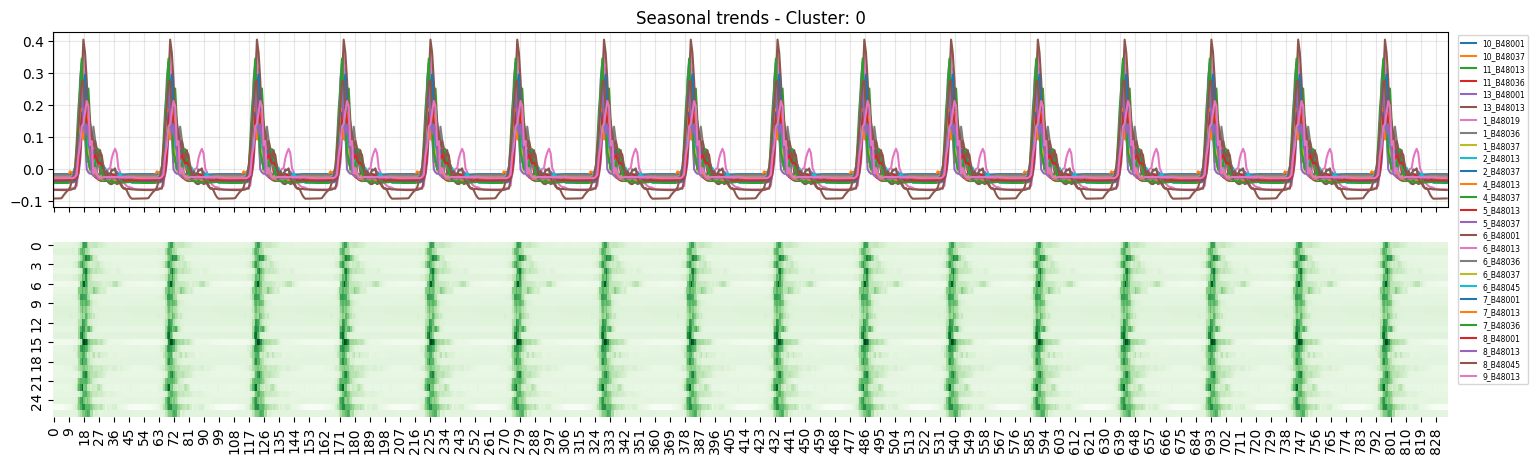

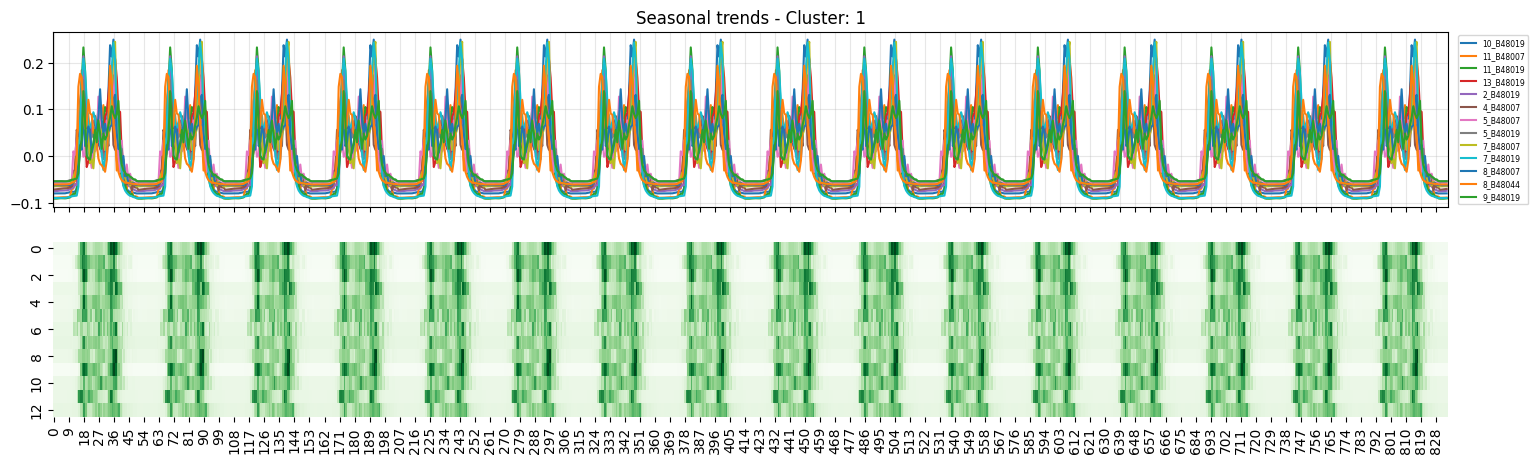

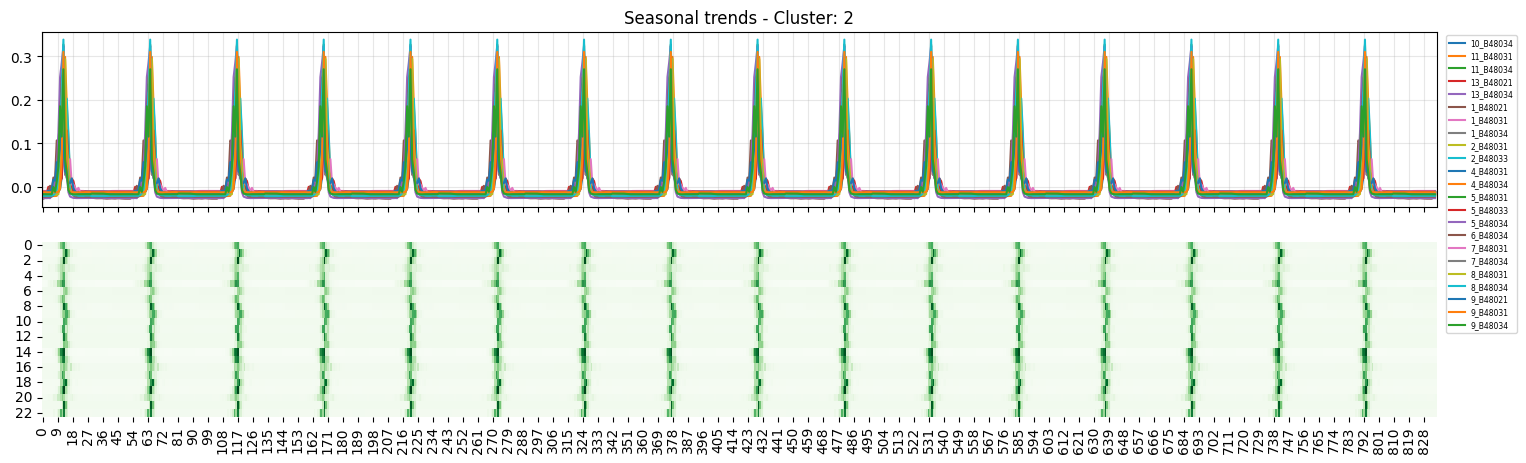

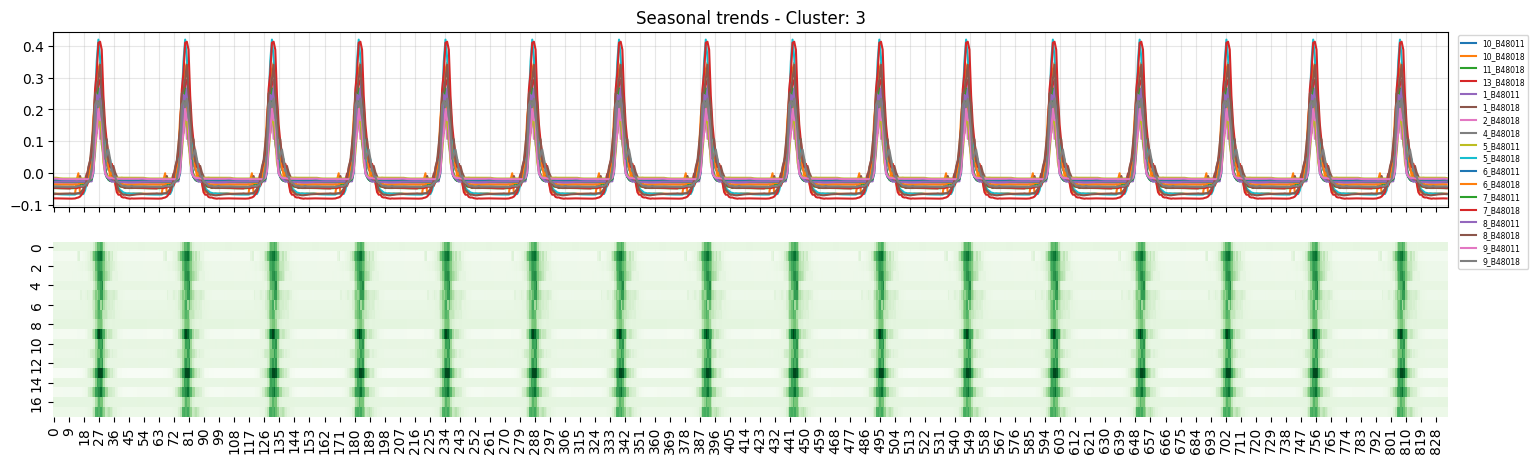

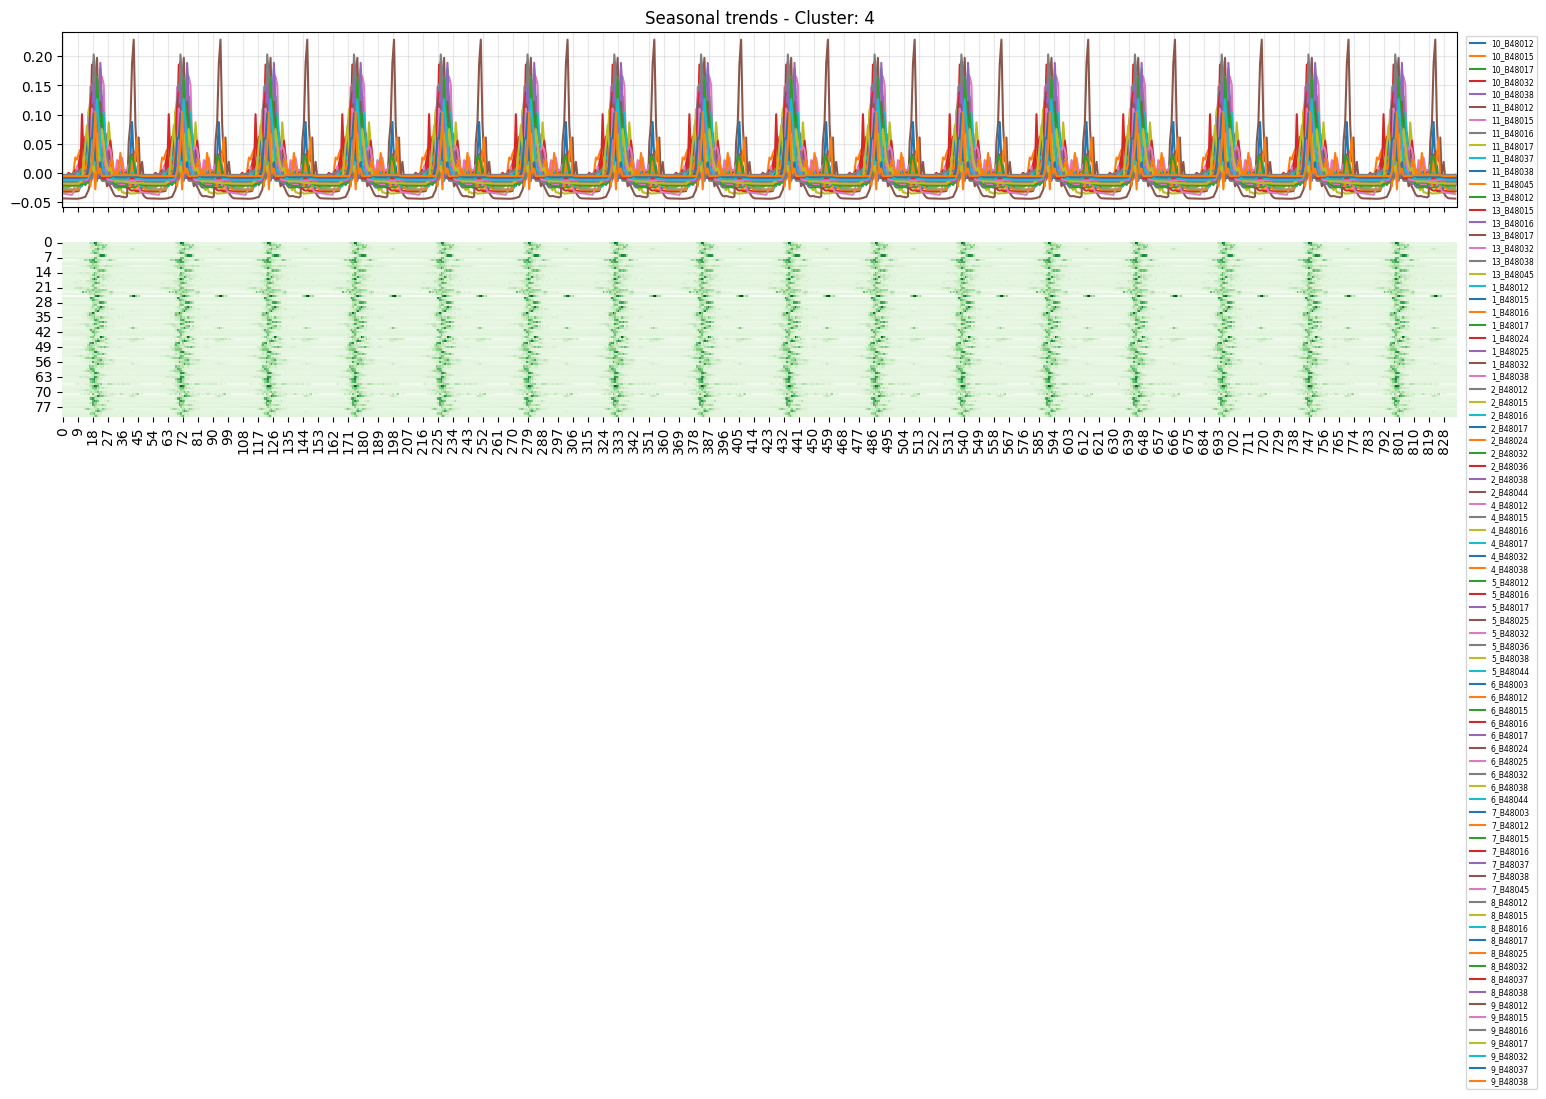

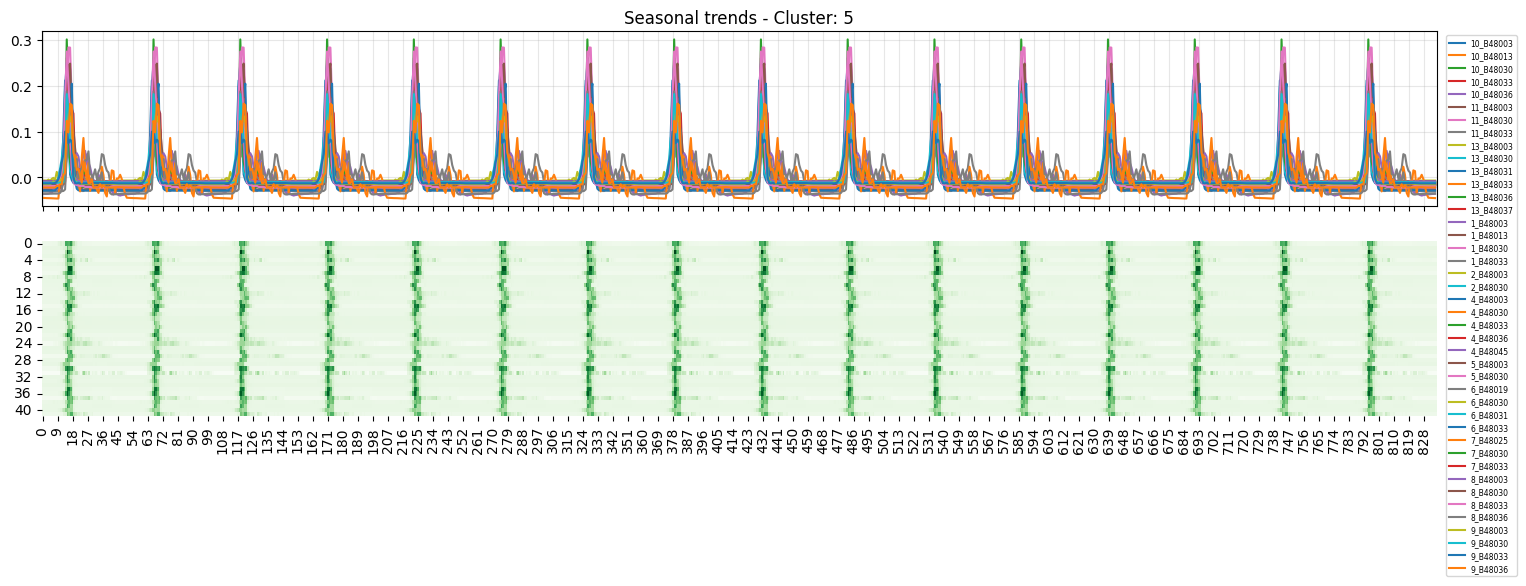

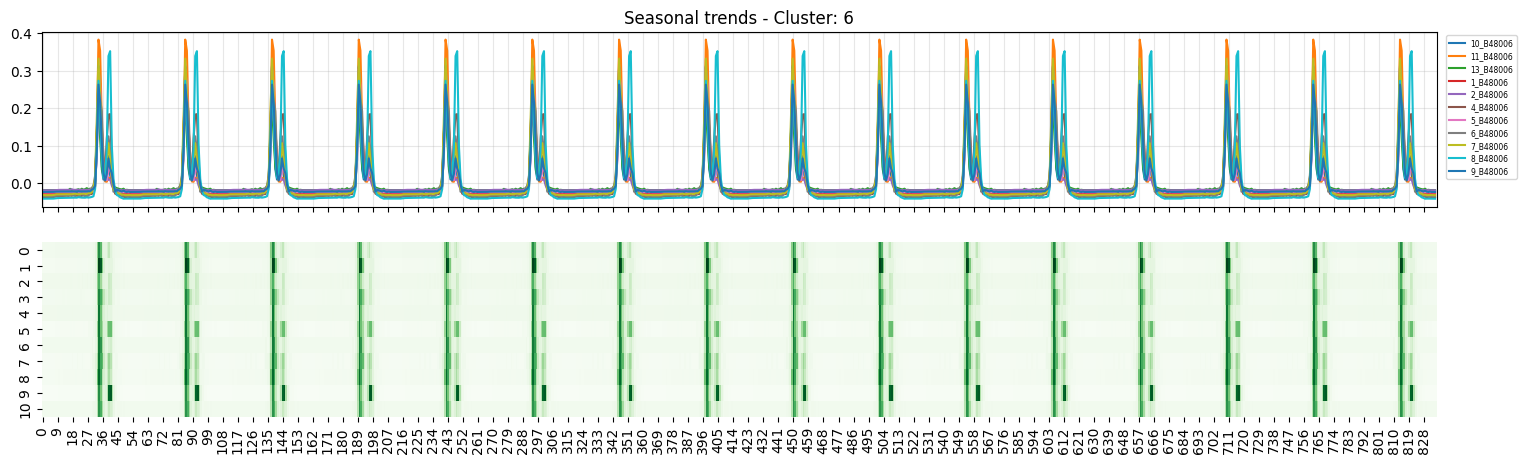

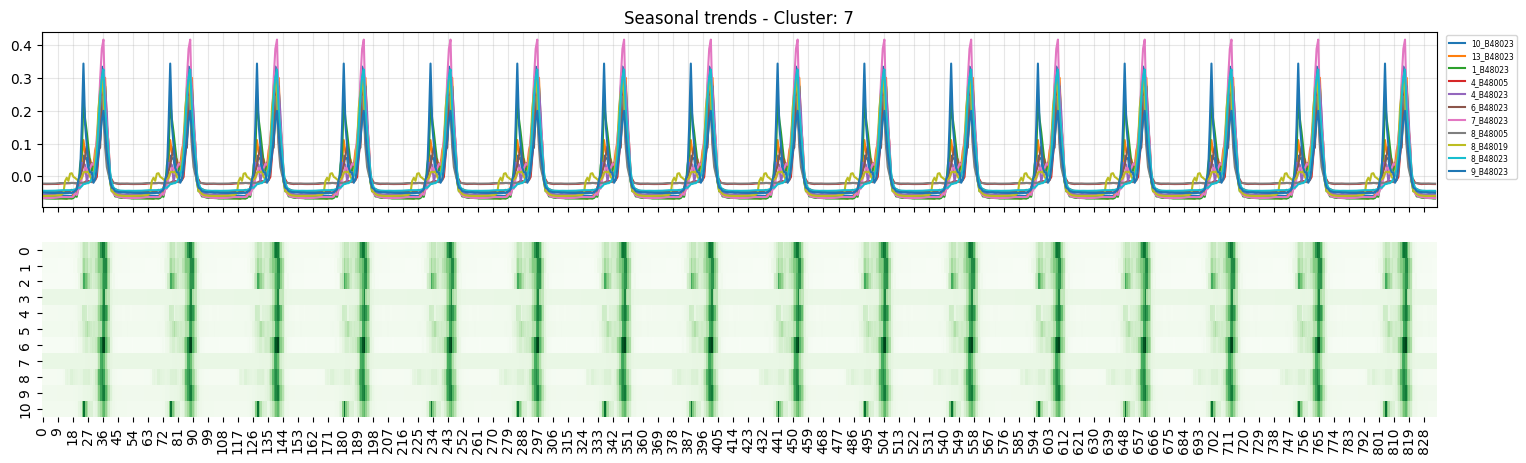

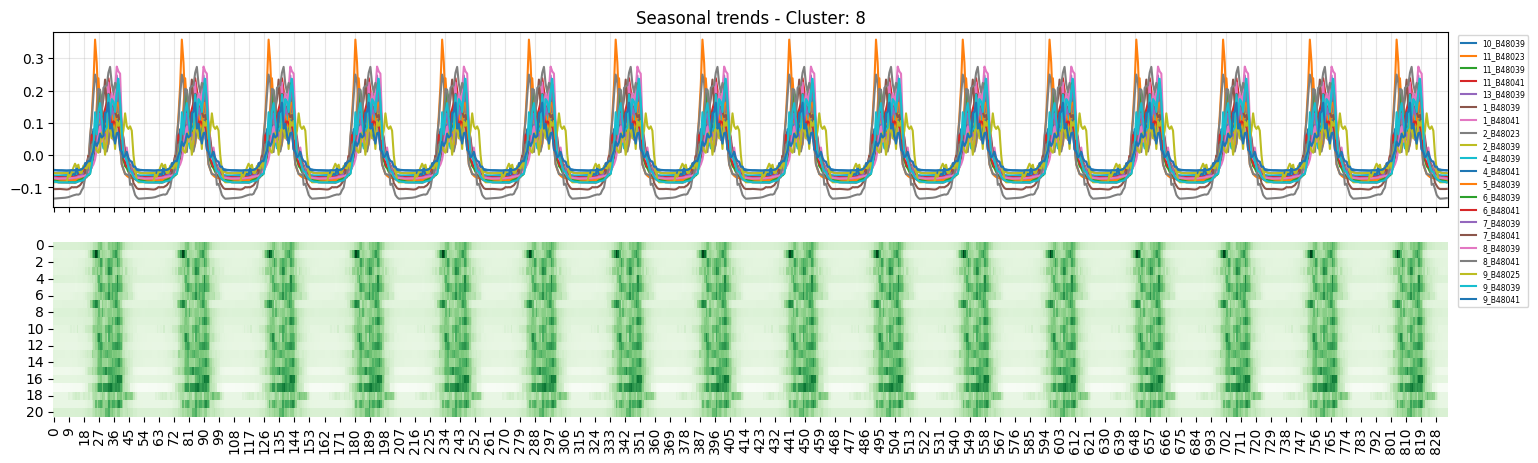

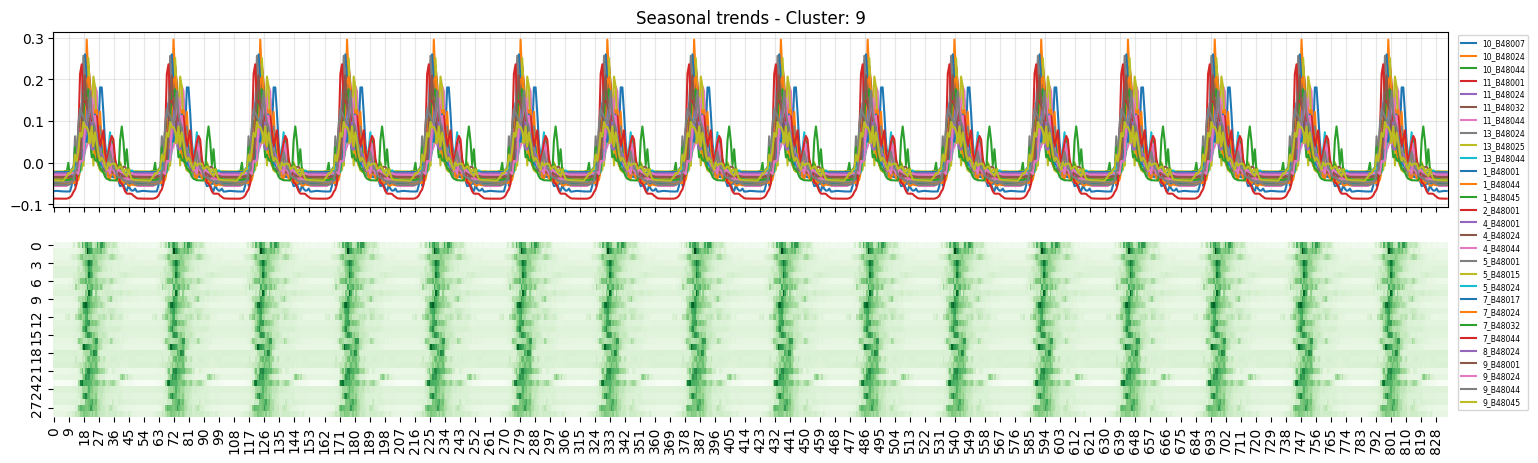

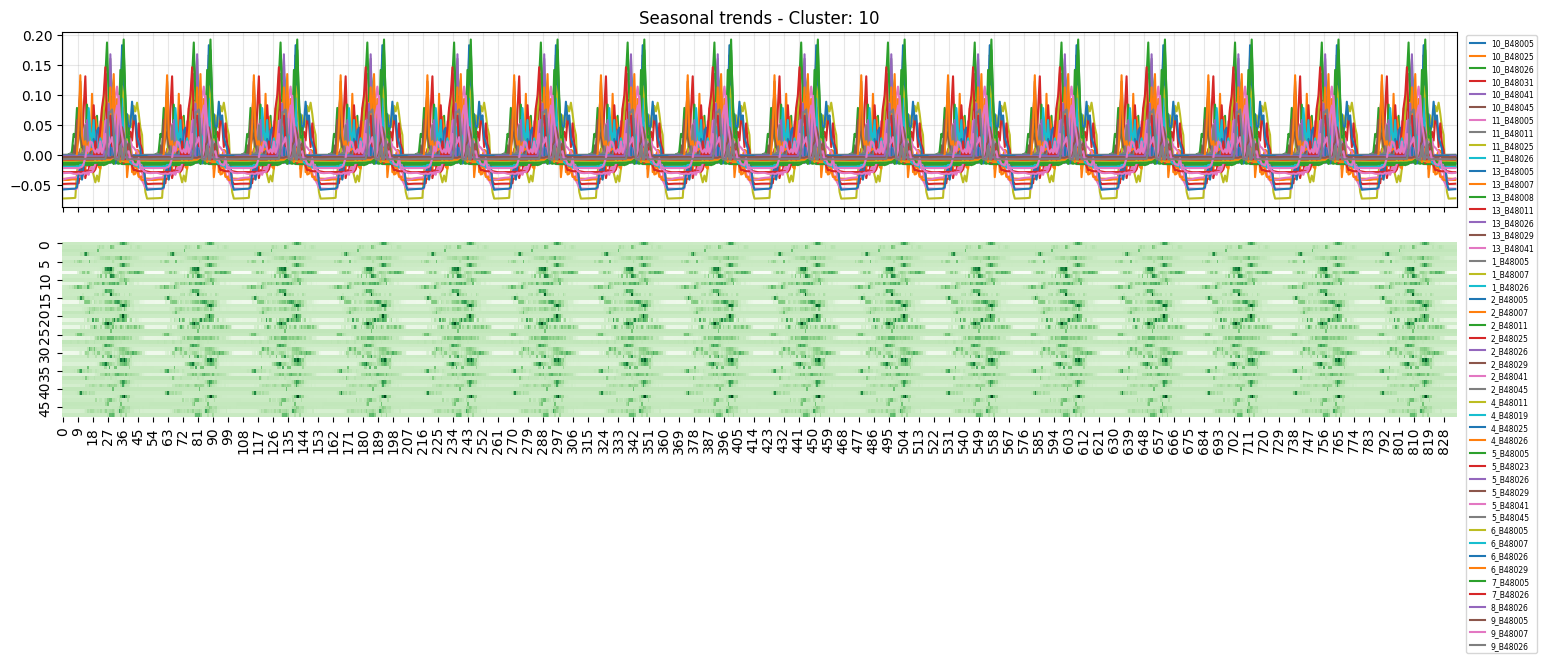

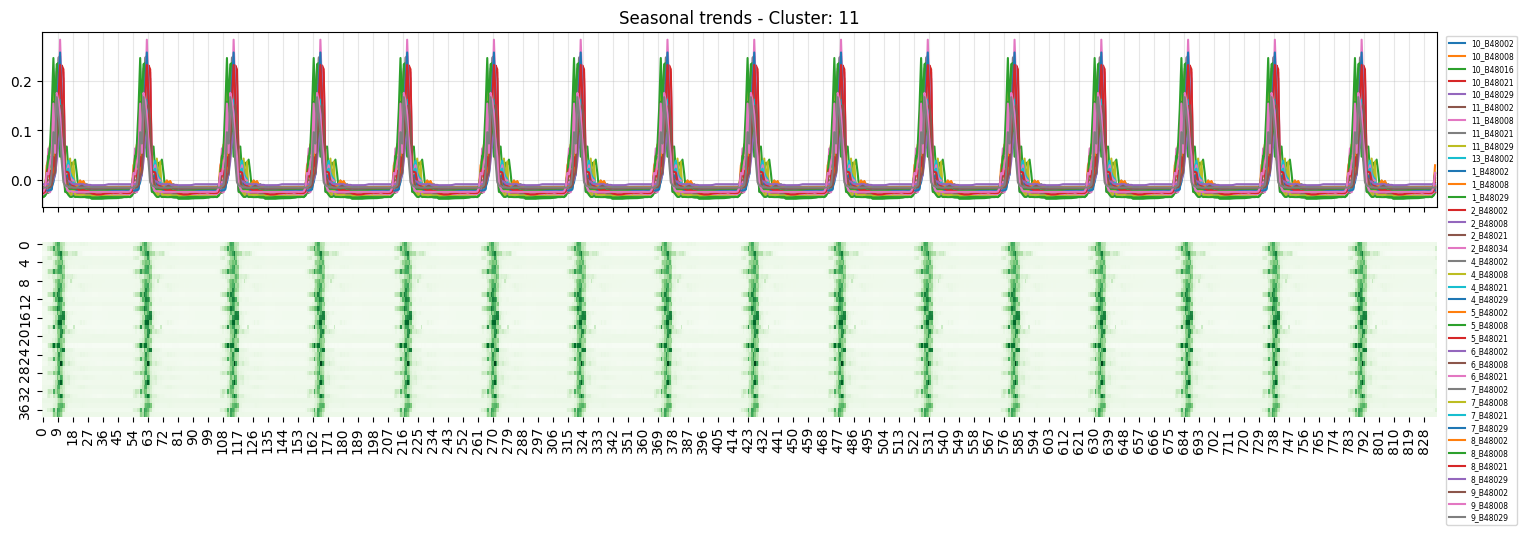

In [20]:
for cluster, species in X.groupby(X.cluster.values.reshape(1,X.cluster.shape[0])[0]):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(18, 5))
    ax1.set_title(f"Seasonal trends - Cluster: {cluster}")

    species.drop("cluster", axis=1, inplace=True, errors="ignore")
    for specie_id, specie_data in species.iterrows():
        ax1.plot(specie_data.values, label=specie_id);
    
    sns.heatmap(species.values, cbar=False, cmap="Greens", ax=ax2);
    
    ax1.grid(alpha=.3)
    ax1.legend(loc="upper right", bbox_to_anchor= (1.06,1), fontsize=5.5)
    #fig.tight_layout()
    fig.show()

## 4.3 Result: Specie pollen clustered

In [22]:
# Get windowed features
df_feat = get_windowed_features(pollen, time_window=optimal_window)

# Pivot dataframe
df_feat = pd.pivot_table(df_feat, values="pol_value", index="station_pol_id", columns="date")

# # Min max scale per specie
df_feat = df_feat.apply(min_max_scale, axis=1).fillna(0)

classes = X["cluster"].to_dict()
df_feat["cluster"] = df_feat.index.map(classes)

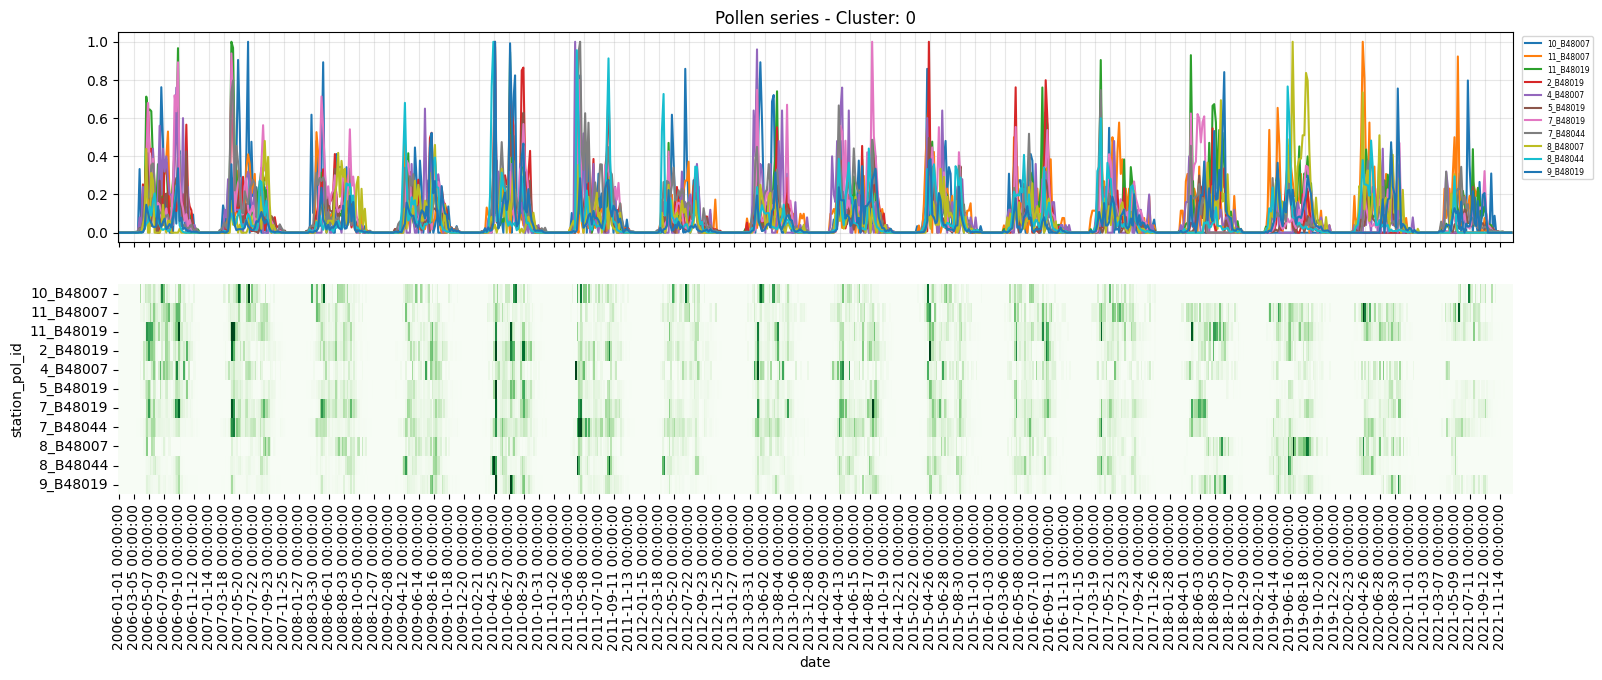

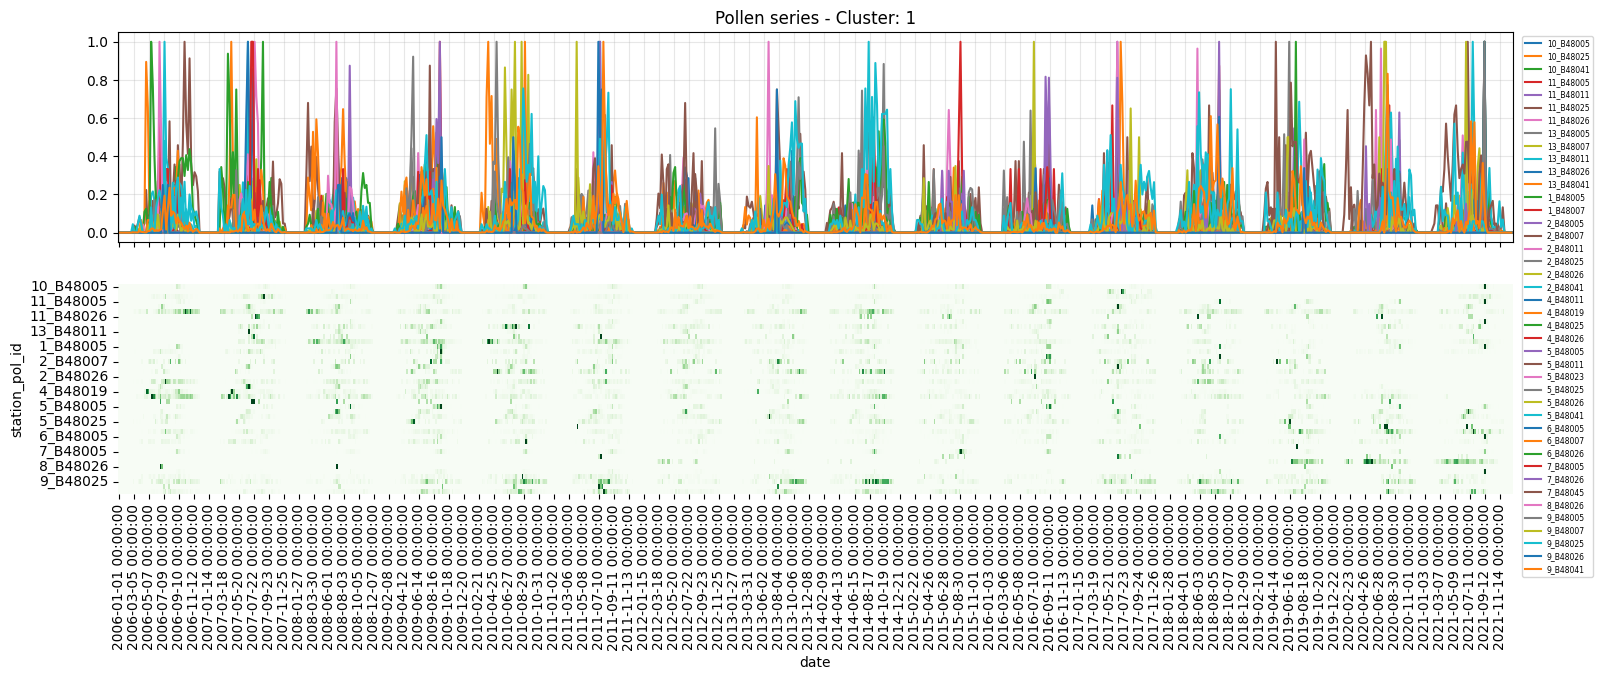

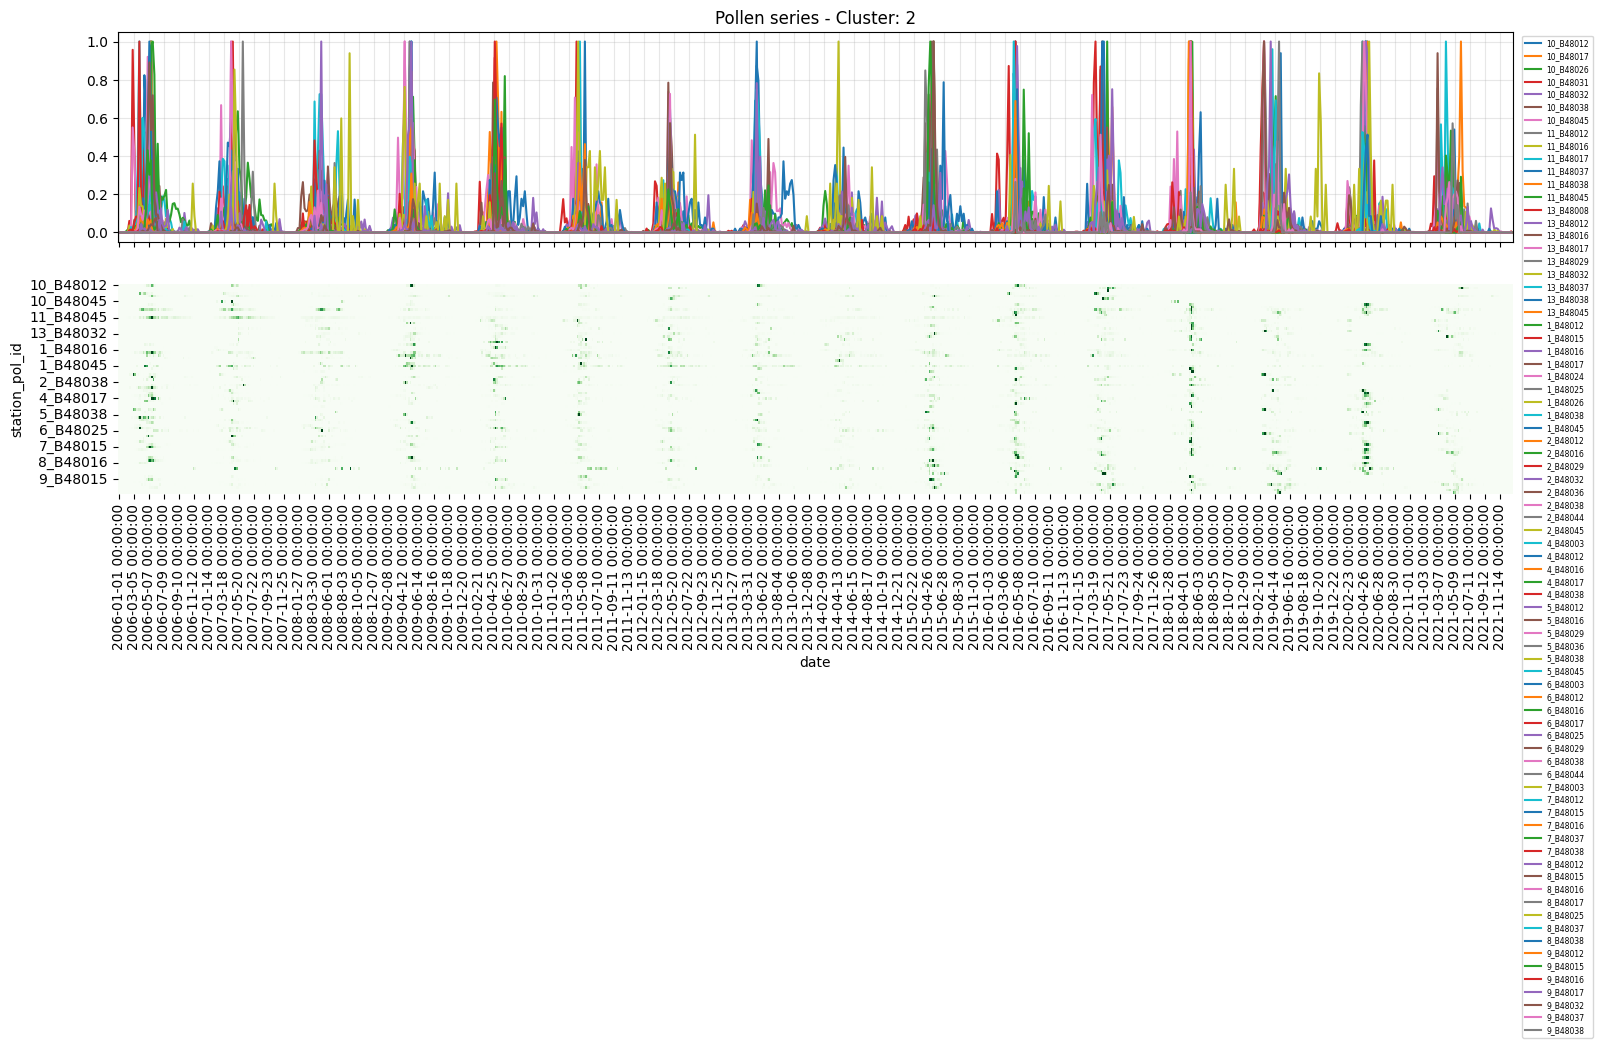

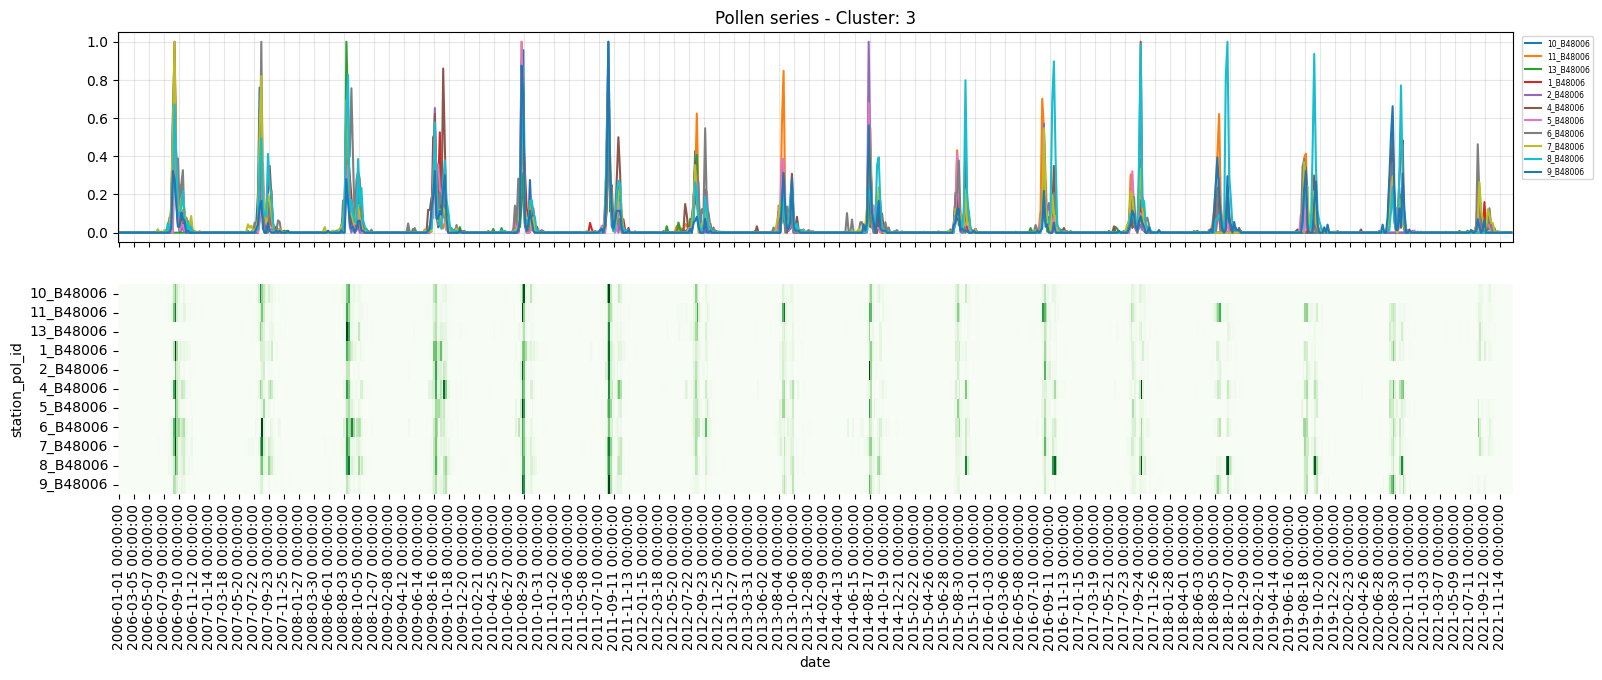

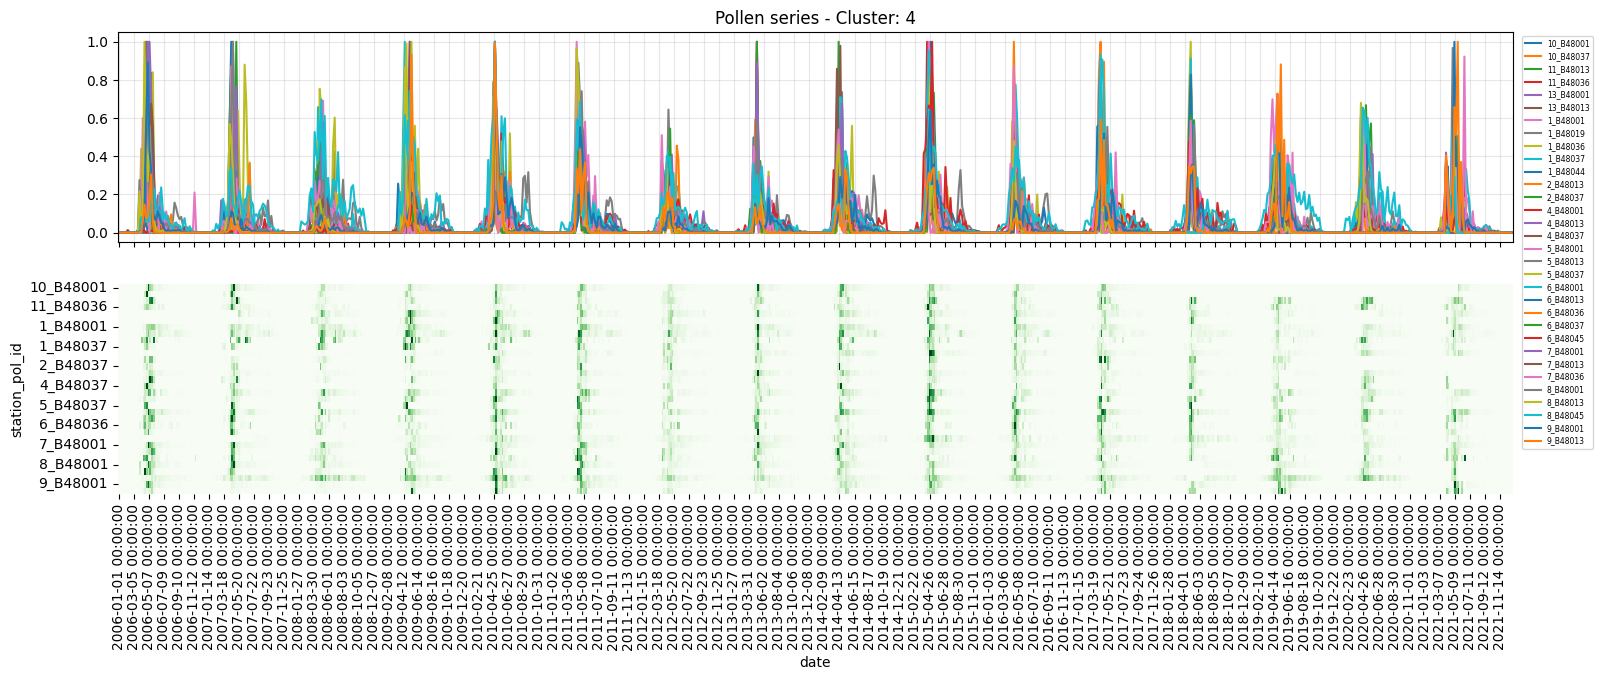

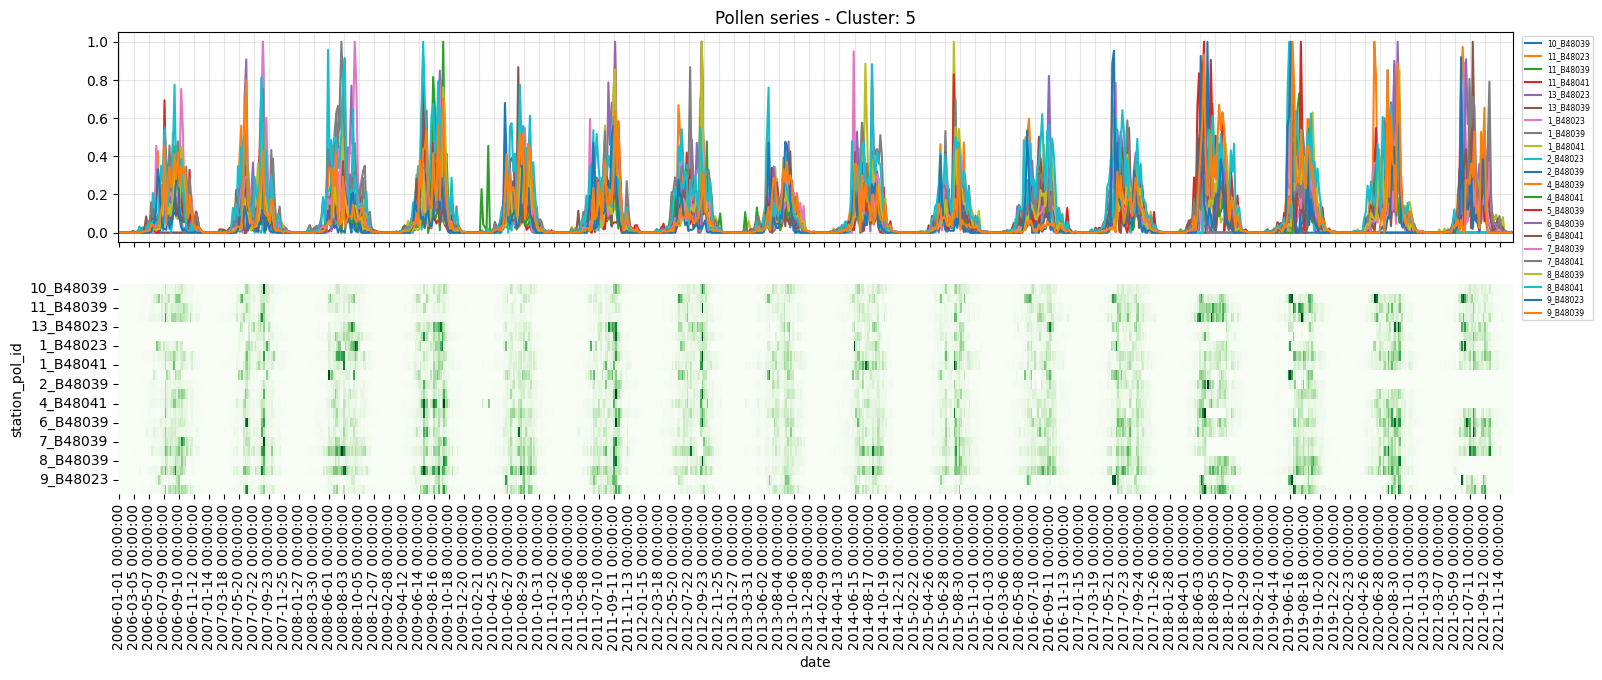

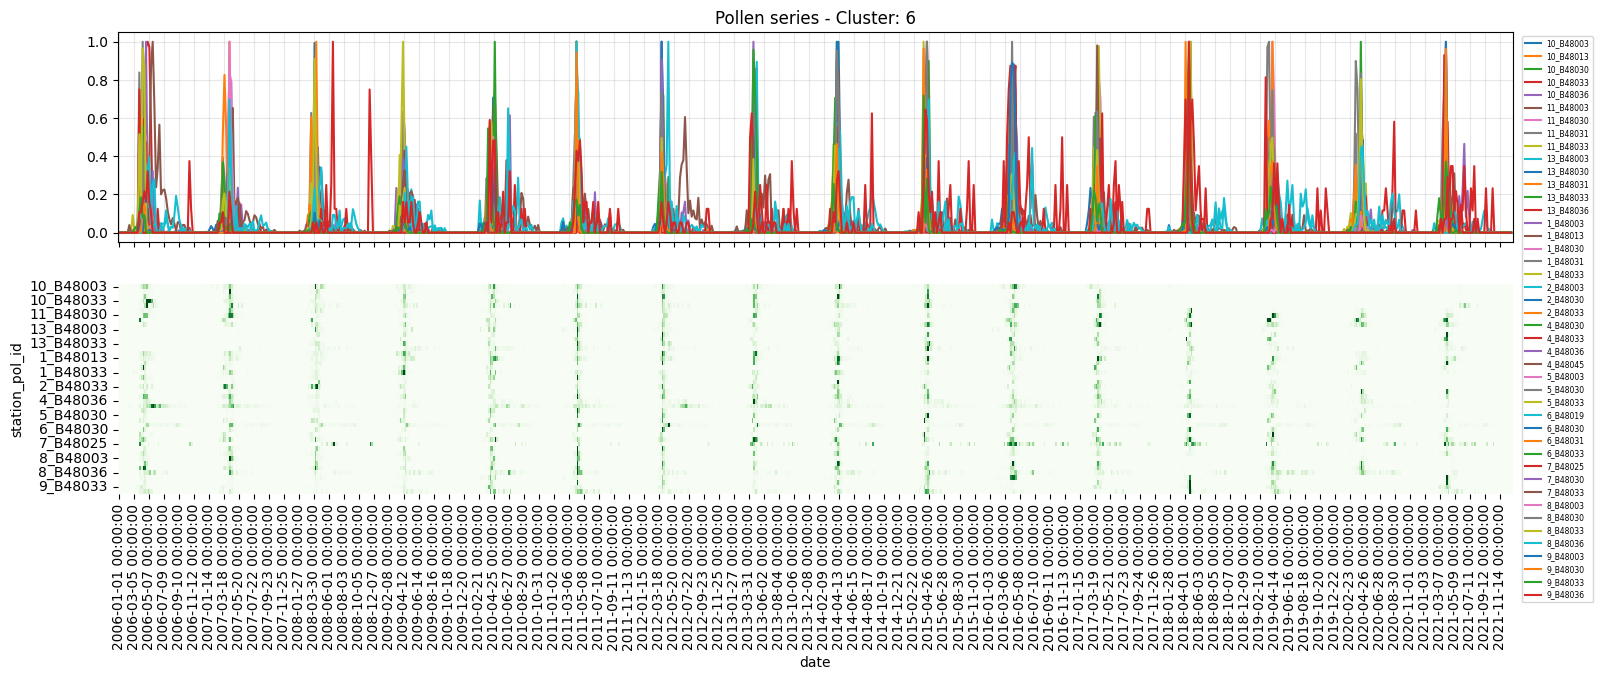

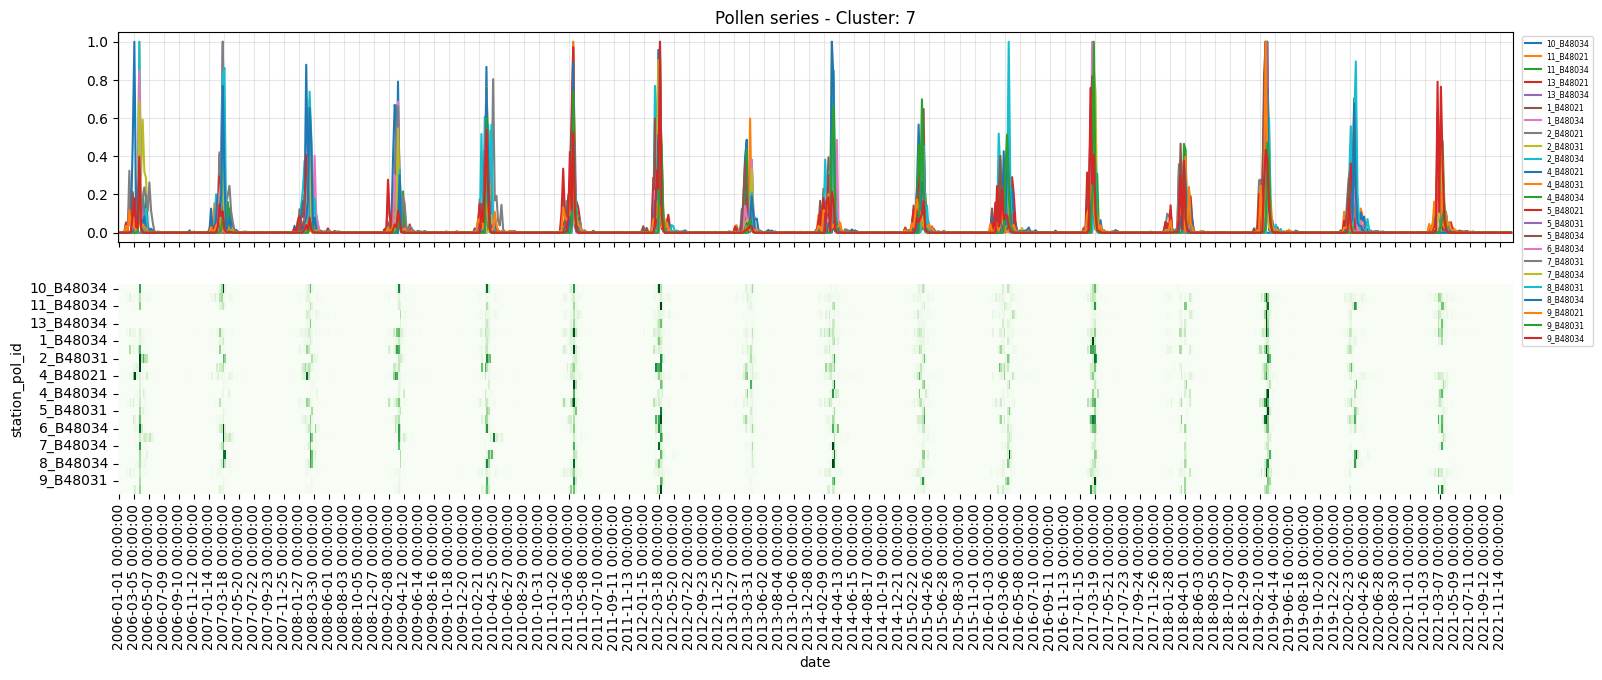

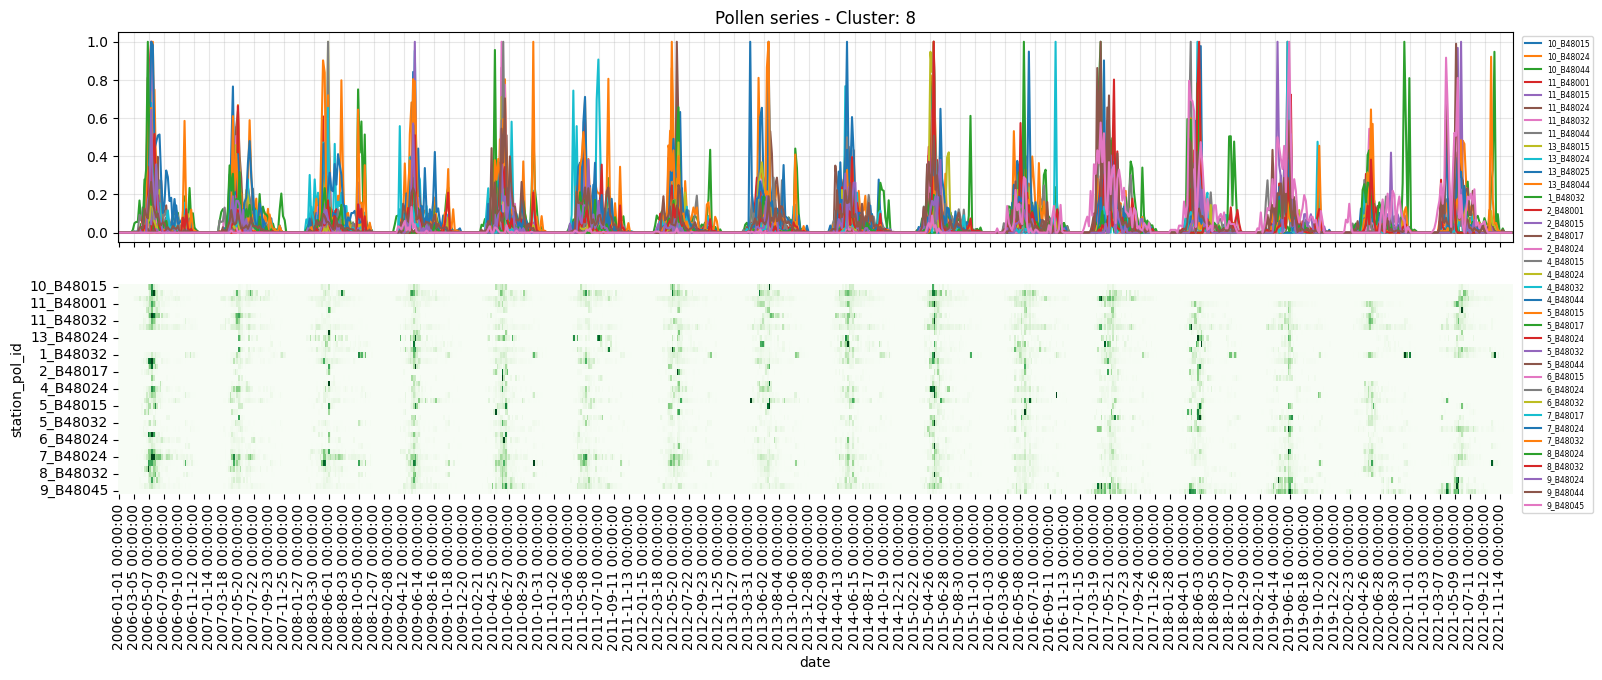

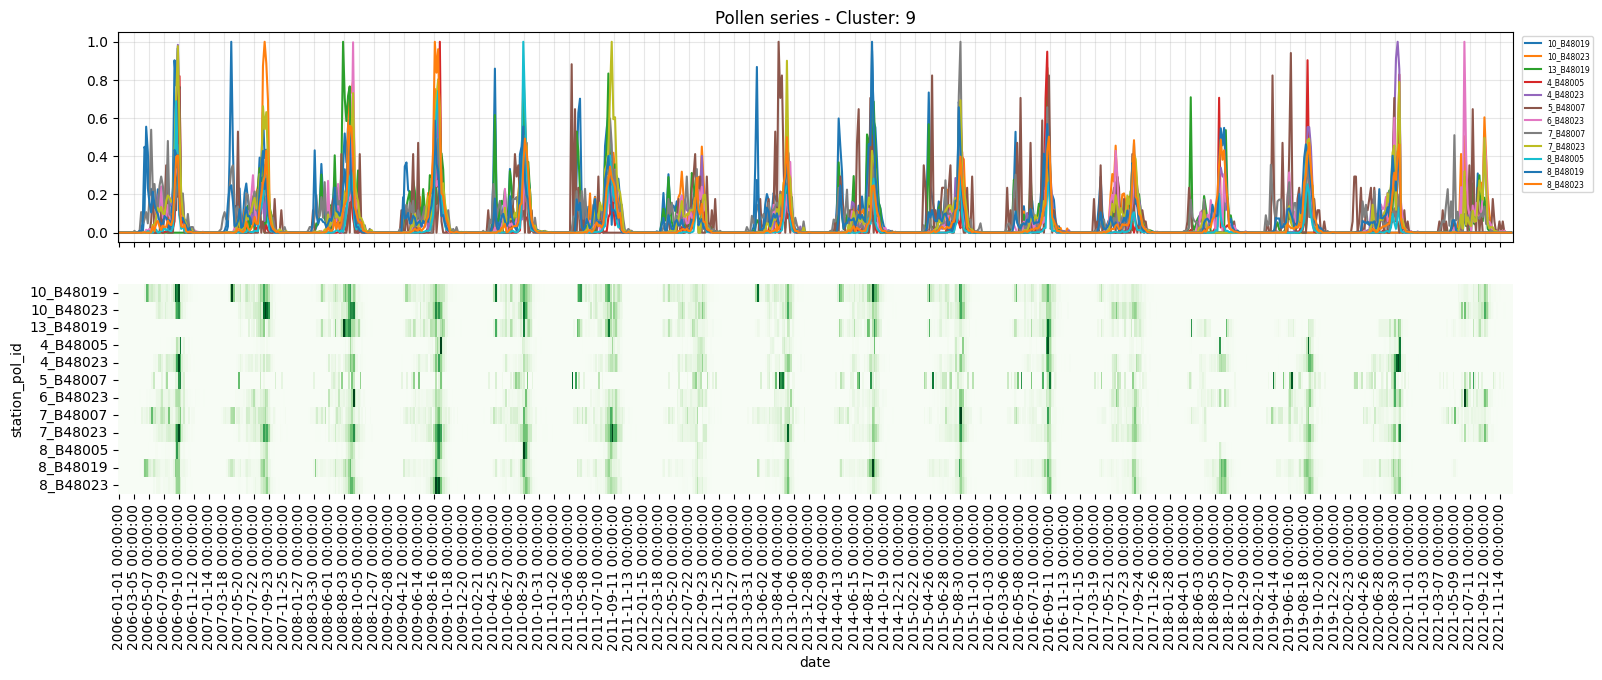

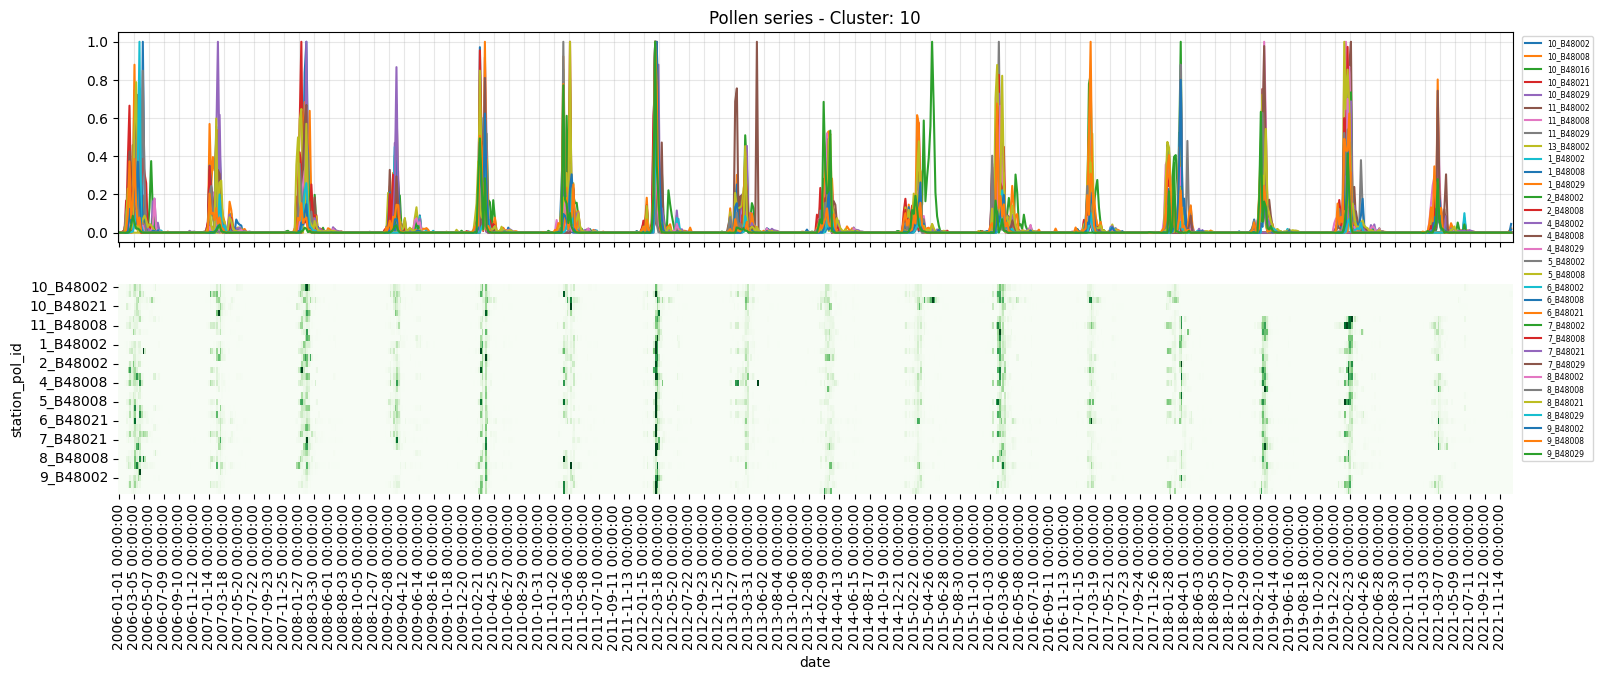

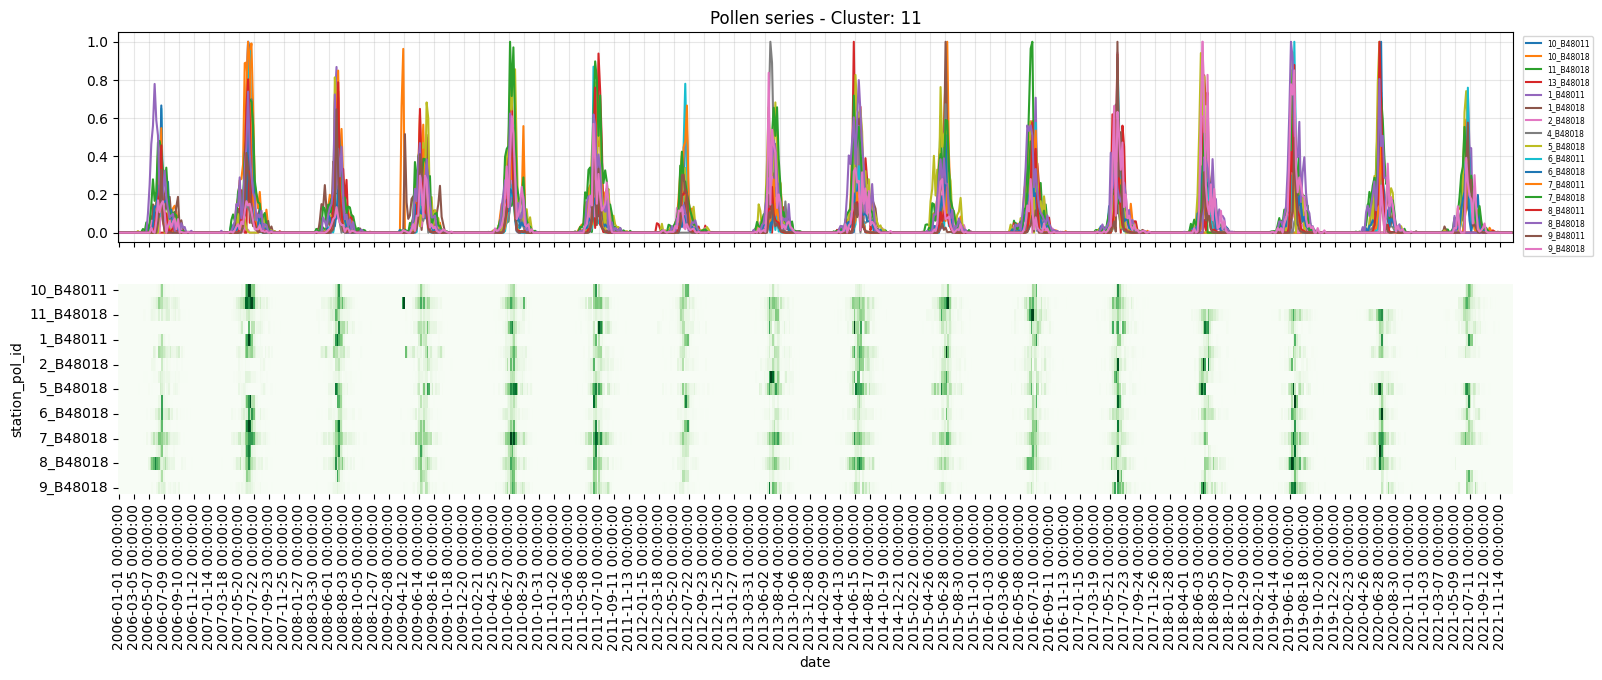

In [27]:
for cluster, species in df_feat.groupby("cluster"):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(18, 6))
    ax1.set_title(f"Pollen series - Cluster: {cluster}")

    species.drop("cluster", axis=1, inplace=True, errors="ignore")
    for specie_id, specie_data in species.iterrows():
        ax1.plot(specie_data.values, label=specie_id);
    
    sns.heatmap(species, cbar=False, cmap="Greens", ax=ax2);
    
    ax1.grid(alpha=.3)
    ax1.legend(loc="upper right", bbox_to_anchor= (1.06,1), fontsize=5.5)
    #fig.tight_layout()
    fig.show()

## 4.4 Result: Station/Species in cluster

In [53]:
df_res = get_windowed_features(pollen, time_window="1W")
df_res[["station_id", "pol_var_id"]] = df_res.apply(lambda s: s.station_pol_id.split("_"), axis=1, result_type="expand")
df_res = pd.merge(df_res, cluster_labels, on=["station_id", "pol_var_id"])

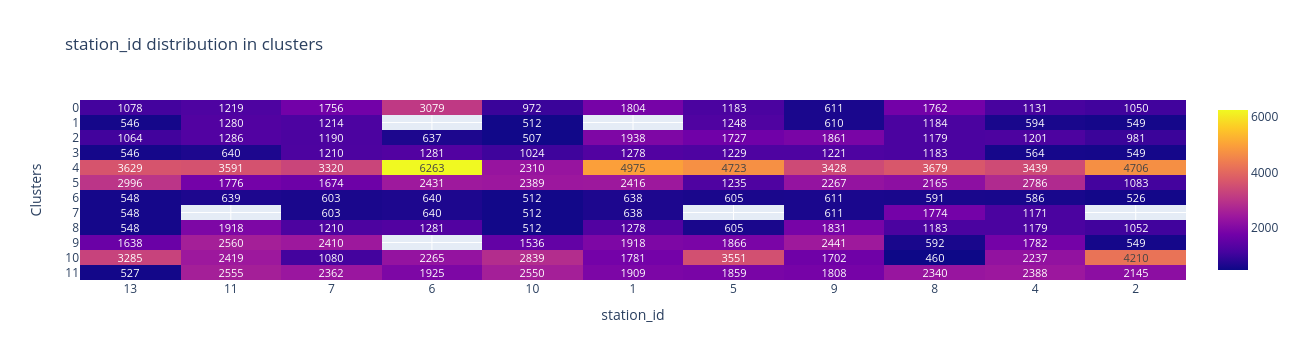

In [54]:
_show_distr_in_clusters(df_res, "station_id", "station_id")

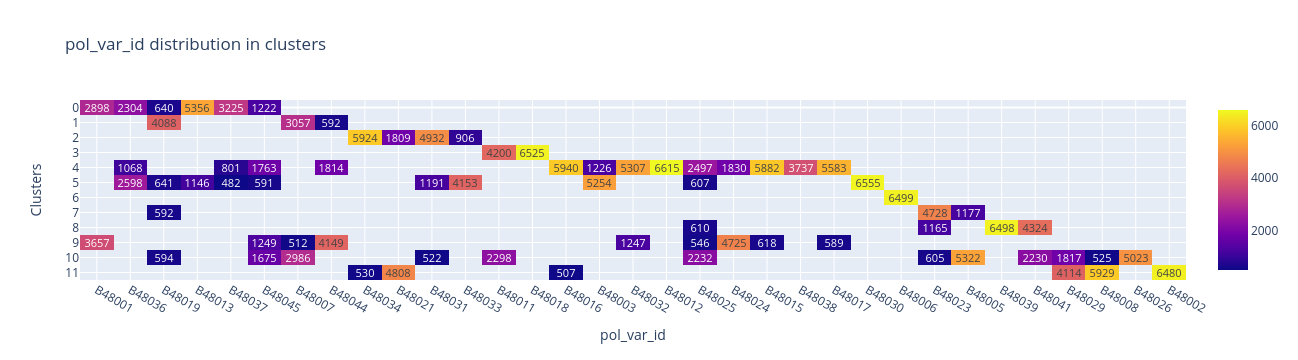

In [55]:
_show_distr_in_clusters(df_res, "pol_var_id", "pol_var_id")

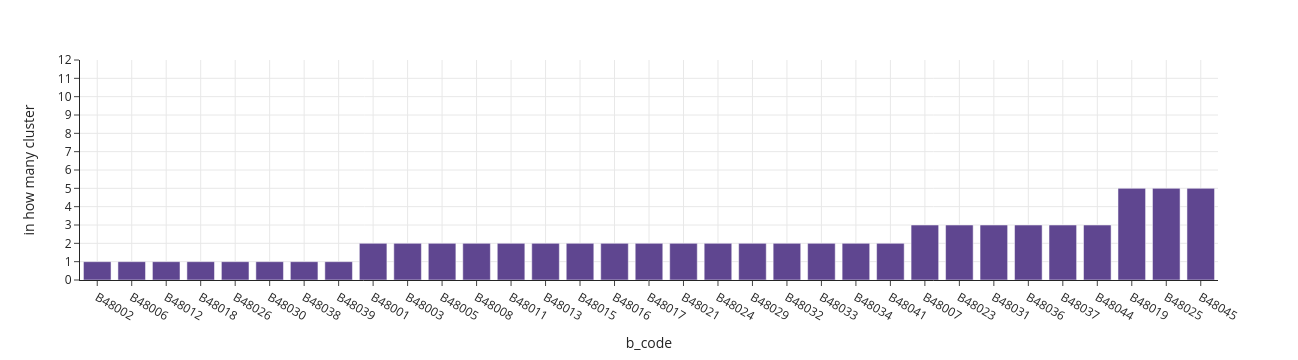

In [56]:
_show_bcode_in_how_many_clusters(df_res)

For n_clusters = 12 The average silhouette_score is : 0.2510197667445545


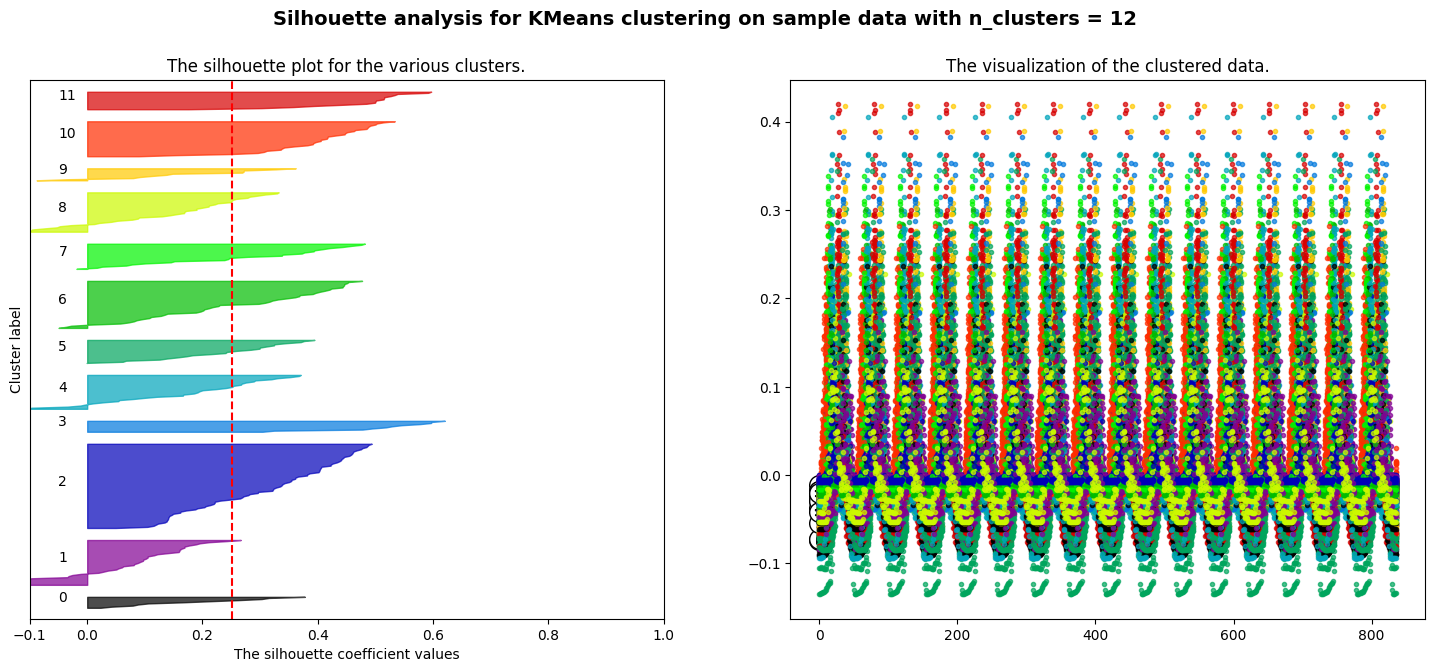

In [28]:
### Silhouette
X.drop("cluster", axis=1, inplace=True, errors="ignore")

n_clusters = df_feat["cluster"].unique().size
cluster_labels = df_feat["cluster"]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

silhouette_avg = silhouette_score(X, df_feat["cluster"])
print("For n_clusters =", n_clusters,"The average silhouette_score is :",silhouette_avg,)

y_lower = 10
sample_silhouette_values = silhouette_samples(X, cluster_labels)
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
for idx, (_, row) in enumerate(X.iterrows()):
    ax2.plot(row.values, marker=".", lw=0, alpha=0.7, c=colors[idx])

centers = clusterer.cluster_centers_
ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
ax2.set_title("The visualization of the clustered data.")
plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold",)

plt.show()

# 5. Store clustering output

In [32]:
cluster_labels = df_feat.reset_index()[["station_pol_id", "cluster"]]
cluster_labels[["station_id", "pol_var_id"]] = cluster_labels.apply(lambda s: s.station_pol_id.split("_"), axis=1, result_type="expand")
cluster_labels[["station_id", "pol_var_id", "cluster"]]

date station_id pol_var_id  cluster
0            10     B48001        0
1            10     B48002       11
2            10     B48003        5
3            10     B48005       10
4            10     B48006        6
..          ...        ...      ...
358           9     B48038        4
359           9     B48039        8
360           9     B48041        8
361           9     B48044        9
362           9     B48045        9

[363 rows x 3 columns]